In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

Requirement already up-to-date: pip in c:\users\wangmi94\appdata\roaming\python\python36\site-packages (19.2.3)
Requirement already up-to-date: numpy in c:\users\wangmi94\appdata\roaming\python\python36\site-packages (1.17.1)


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Sequential

C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Py

# Model Building

## Load data and do data normalization

In [3]:
def moneyness(S,X):
    return S/X

In [4]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [5]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    # In the money
    ITM_df = sample_df[sample_df['moneyness'] <= 0.97] 
    # At the money
    ATM_df = sample_df[sample_df['moneyness'].between(0.97,
                        1.03, inclusive = False)] 
    # Out of the money
    OTM_df = sample_df[sample_df['moneyness'] >= 1.03] 
    
    return sample_df, ITM_df, ATM_df, OTM_df

In [6]:
sample_df, ITM_df, ATM_df, OTM_df = load_data('Options_R_new.csv')

In [7]:
print('option data shape:', sample_df.shape)
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

option data shape: (1700235, 11)
In-The_Money option data shape: (687300, 11)
An-The_Money option data shape: (262052, 11)
Out-The_Money option data shape: (750883, 11)


In [8]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

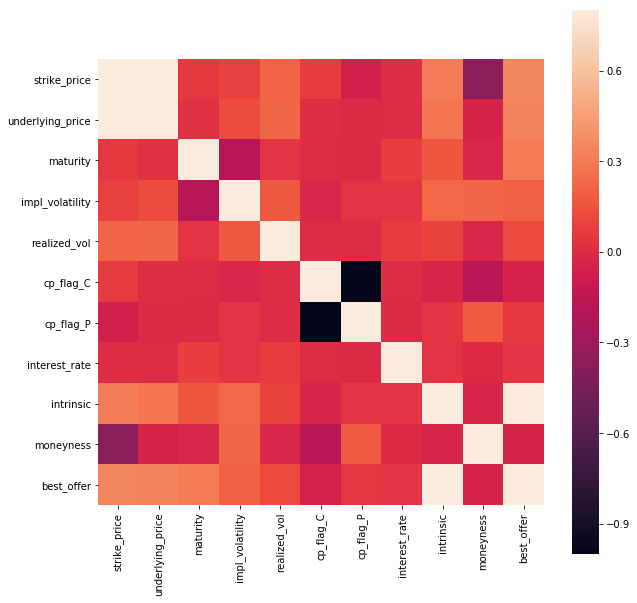

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [9]:
corr = get_corr(sample_df)

In [10]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
    y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test#, sc_X, sc_y

## Build model with in-the-money option data

In [27]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM = data(ITM_df)

In [12]:
print(X_train_ITM[:10])
print(y_test_ITM[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
1616882       0.00         111.0            102.84        16         0.173117   
1010909       0.00         110.0             81.56       309         0.194168   
677456        9.84         170.0            160.16       148         0.166219   
581542        0.00          50.0             41.41        15         0.388734   
456810        0.00         120.0             92.88       180         0.193109   
1282233      15.99         207.5            191.51        35         0.227236   
717418        0.00         235.0            184.04        10         0.547157   
1346286      20.31         225.0            204.69       165         0.172871   
562445        2.97          45.0             42.03         7         0.296552   
317422        0.00         100.0             96.13       172         0.141775   

         cp_flag_P  interest_rate  
1616882          0         0.0001  
1010909          0         0.0003  


In [14]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def ABS(x):
    return K.abs(x)

def exp(x):
    return K.exp(x)

In [15]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = ABS))
    
    #optimizer = Adam()
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (14, 10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

W0827 13:59:03.147526  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 13:59:03.161548  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 13:59:03.163536  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 13:59:03.225594  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 494856 samples, validate on 54984 samples
Epoch 1/200
494856/494856 [==============================] - 8s 17us/step - loss: 15.7544 - mean_absolute_error: 1.3825 - val_loss: 0.6357 - val_mean_absolute_error: 0.4799
Epoch 2/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.6868 - mean_absolute_error: 0.5056 - val_loss: 1.1947 - val_mean_absolute_error: 0.6077
Epoch 3/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.6955 - mean_absolute_error: 0.4961 - val_loss: 0.4366 - val_mean_absolute_error: 0.3944
Epoch 4/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.5609 - mean_absolute_error: 0.4452 - val_loss: 0.5448 - val_mean_absolute_error: 0.4943
Epoch 5/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.4870 - mean_absolute_error: 0.4154 - val_loss: 0.6639 - val_mean_absolute_error: 0.4933
Epoch 6/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.4696

494856/494856 [==============================] - 8s 16us/step - loss: 0.1542 - mean_absolute_error: 0.2133 - val_loss: 0.1128 - val_mean_absolute_error: 0.1831
Epoch 96/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1364 - mean_absolute_error: 0.2008 - val_loss: 0.1211 - val_mean_absolute_error: 0.1908
Epoch 97/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1556 - mean_absolute_error: 0.2159 - val_loss: 0.2194 - val_mean_absolute_error: 0.2474
Epoch 98/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1501 - mean_absolute_error: 0.2096 - val_loss: 0.3506 - val_mean_absolute_error: 0.3350
Epoch 99/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1442 - mean_absolute_error: 0.2064 - val_loss: 0.1531 - val_mean_absolute_error: 0.2201
Epoch 100/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1395 - mean_absolute_error: 0.2037 - val_loss: 0.1116 - val_me

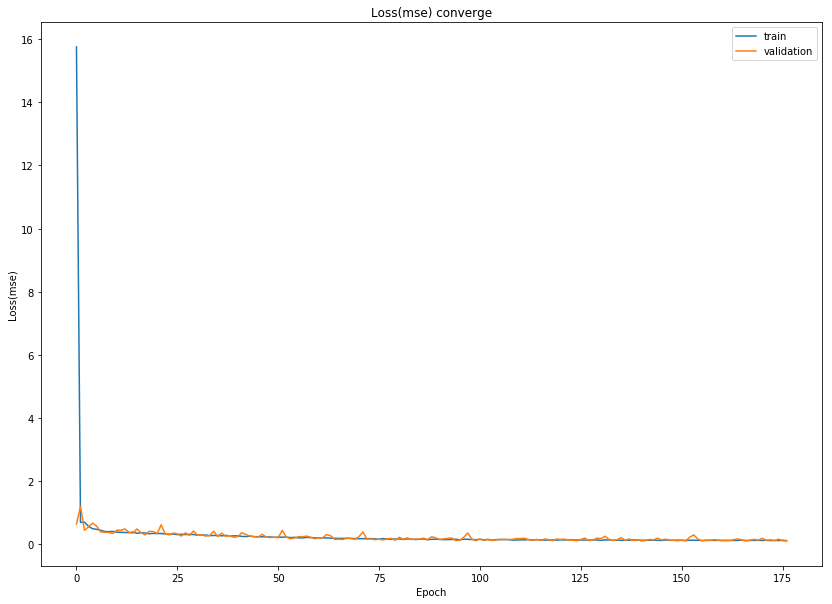

Wall time: 24min 36s


In [15]:
%time model_ITM, result_ITM = create_model(X_train_ITM, y_train_ITM)

In [16]:
def pred(model, X, y):
    
    pred = model.predict(X)

#     pred = sc_y.inverse_transform(pred)
#     y = sc_y.inverse_transform(y)

    pred = pred.flatten()
    y = y.flatten()

    d = {'predicted': pred, 'actual': y}
    pred_df = pd.DataFrame(data = d)
    display(pred_df.head(10))

    pred_sample = pred_df.sample(n = 150)

    pred_sample.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(pred_sample.index, pred_sample['predicted'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(pred_sample.index, pred_sample['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(pred_sample['predicted']-pred_sample['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
#     print(binEdges)
#     bincenters = binEdges[1:]+binEdges[:-1]
#     print(bincenters)
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
    
        
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist(pred_df['predicted']-pred_df['actual'], 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    plt.grid(True)
    plt.ylim(0,1)
    plt.show()
    #print('The percentage of abs error less than 1:', CountPairsPrecent(pred_sample['predicted'], pred_sample['actual'], len(pred_sample)))
    #plt.plot(pred_sample.index, np.abs(pred_sample['predicted']-pred_sample['actual']), linestyle = '-', label = 'predicted', color = 'r')
    print('\n')
    print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y,pred))
    print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y,pred))
    print("R square (R^2):            %f" % skm.r2_score(y,pred))

,predicted,actual
0,0.323040,0.27
1,0.411613,0.47
2,32.194916,30.20
3,8.319988,7.75
4,0.052406,0.05
5,0.527764,0.50
6,0.099559,0.10
7,7.369299,7.05
8,0.178044,0.13
9,0.118669,0.11


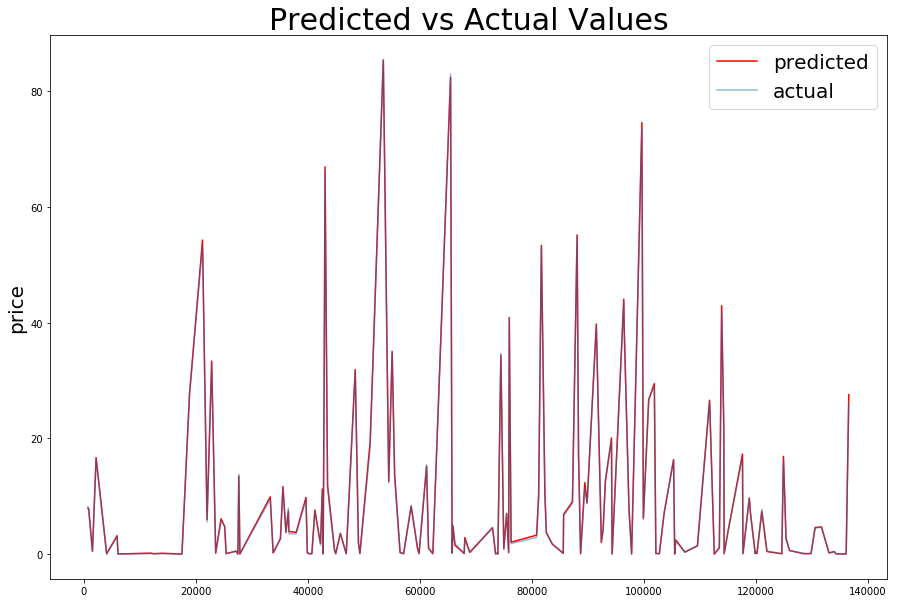

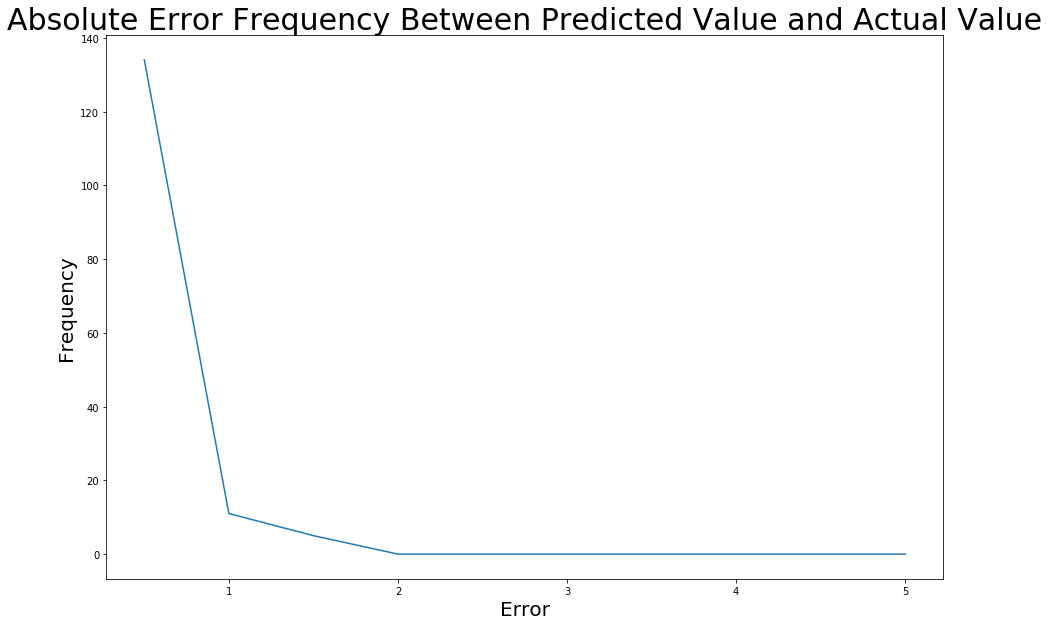

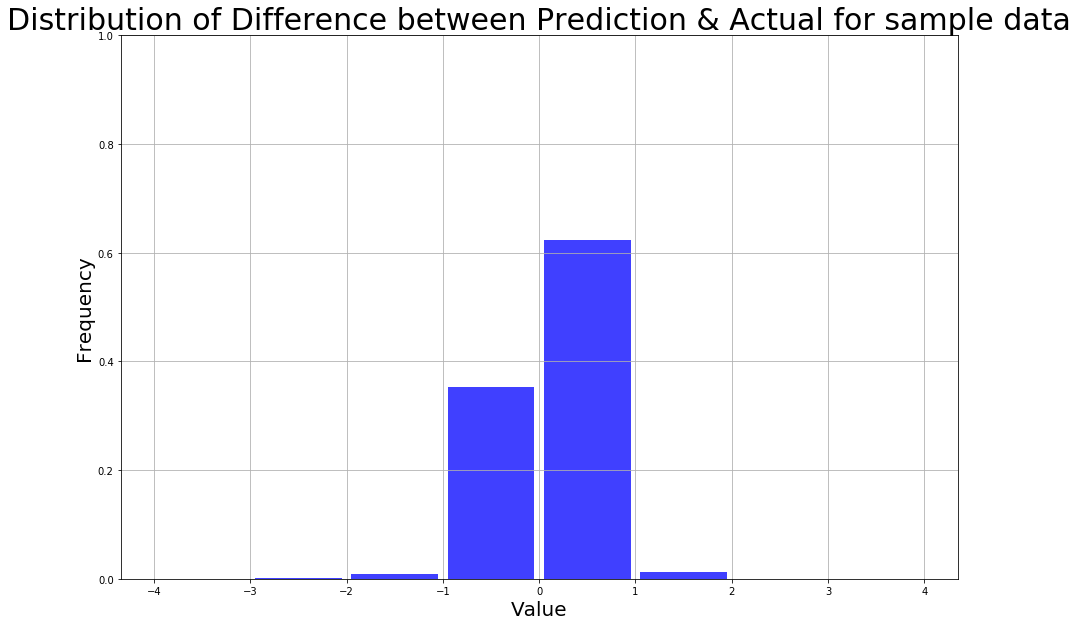



Mean absolute error (MAE): 0.174261
Mean squared error (MSE):  0.105299
R square (R^2):            0.999522


In [17]:

pred_ITM = pred(model_ITM, X_test_ITM, y_test_ITM)

In [18]:
model_ITM.save('model4_2_ITM_ori_abs.h5')

## Build model with at-the-money option data

In [28]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM = data(ATM_df)

Train on 188676 samples, validate on 20965 samples
Epoch 1/200
188676/188676 [==============================] - 4s 20us/step - loss: 7.5553 - mean_absolute_error: 1.2887 - val_loss: 1.5706 - val_mean_absolute_error: 0.9252
Epoch 2/200
188676/188676 [==============================] - 3s 18us/step - loss: 1.2309 - mean_absolute_error: 0.7705 - val_loss: 1.5827 - val_mean_absolute_error: 0.7900
Epoch 3/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.9511 - mean_absolute_error: 0.6372 - val_loss: 0.8840 - val_mean_absolute_error: 0.6228
Epoch 4/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.7861 - mean_absolute_error: 0.5640 - val_loss: 0.9870 - val_mean_absolute_error: 0.6519
Epoch 5/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.7673 - mean_absolute_error: 0.5616 - val_loss: 0.8558 - val_mean_absolute_error: 0.5812
Epoch 6/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.7030 

188676/188676 [==============================] - 3s 16us/step - loss: 0.1236 - mean_absolute_error: 0.1977 - val_loss: 0.1295 - val_mean_absolute_error: 0.1940
Epoch 96/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1283 - mean_absolute_error: 0.1954 - val_loss: 0.2616 - val_mean_absolute_error: 0.3055
Epoch 97/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1394 - mean_absolute_error: 0.2104 - val_loss: 0.1397 - val_mean_absolute_error: 0.2313
Epoch 98/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.1362 - mean_absolute_error: 0.2079 - val_loss: 0.3386 - val_mean_absolute_error: 0.3221
Epoch 99/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.1085 - mean_absolute_error: 0.1845 - val_loss: 0.1130 - val_mean_absolute_error: 0.1824
Epoch 100/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1113 - mean_absolute_error: 0.1879 - val_loss: 0.0960 - val_me

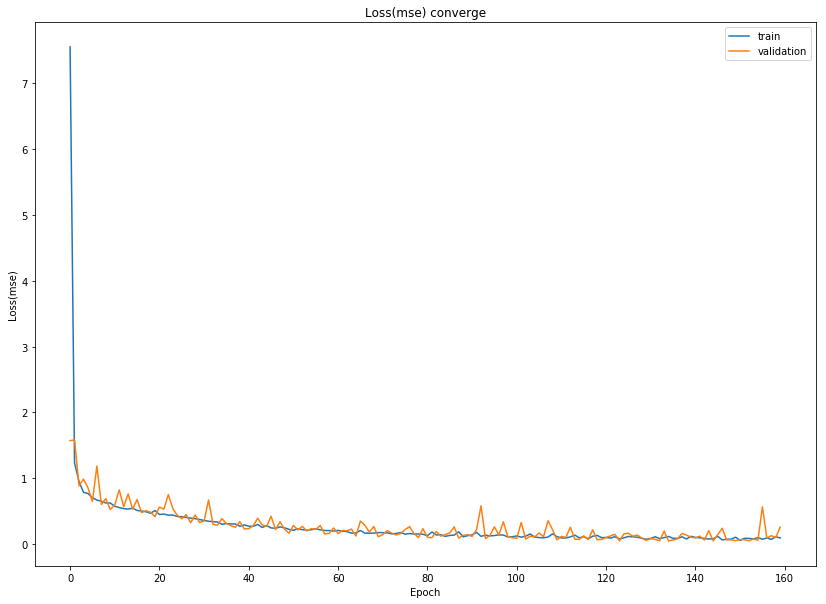

Wall time: 8min 18s


In [20]:
%time model_ATM, result_ATM = create_model(X_train_ATM, y_train_ATM)

,predicted,actual
0,1.157884,0.88
1,2.082313,1.93
2,7.998956,7.70
3,3.809023,3.45
4,0.718842,0.62
5,0.679713,0.59
6,1.441546,1.38
7,0.669994,0.53
8,2.845711,2.49
9,0.444366,0.44


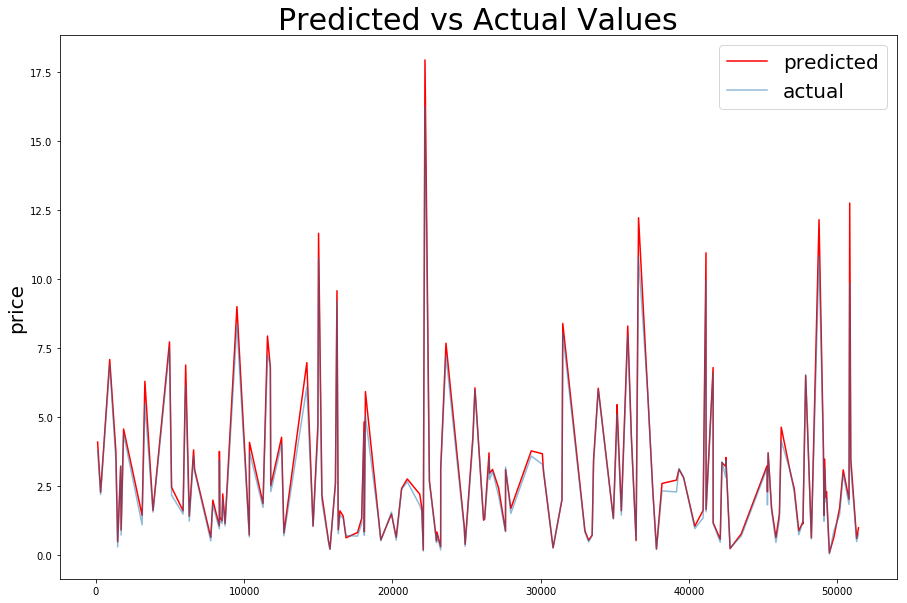

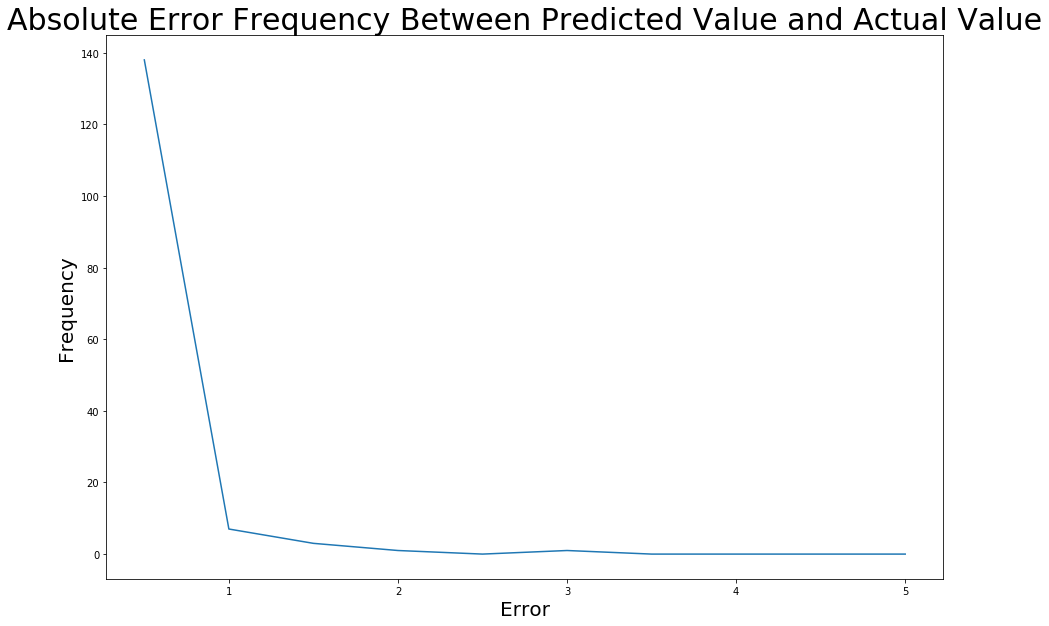

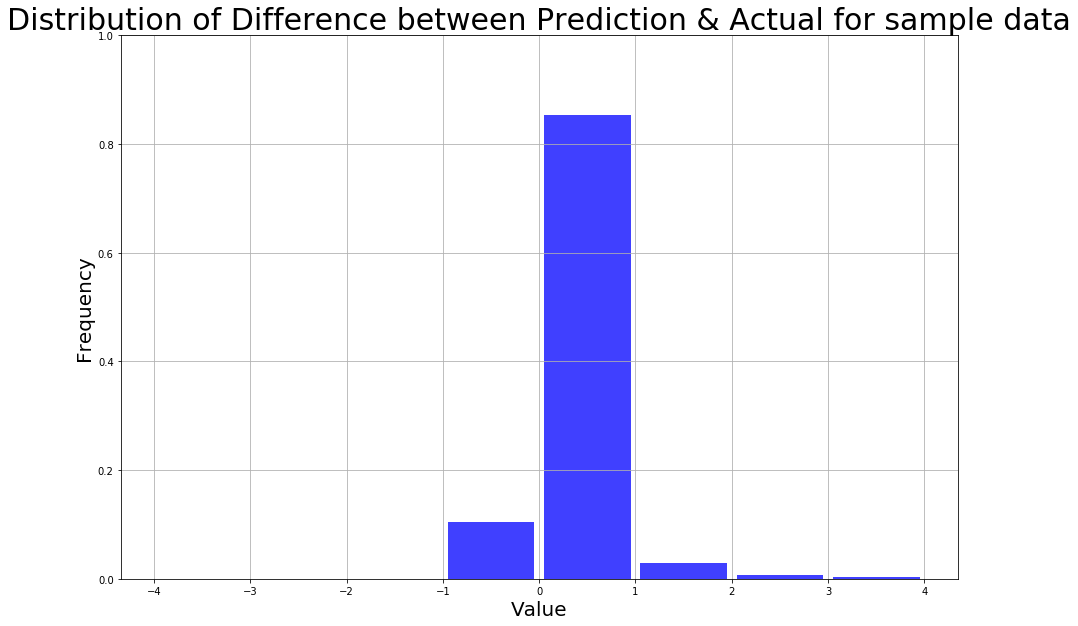



Mean absolute error (MAE): 0.291775
Mean squared error (MSE):  0.260943
R square (R^2):            0.980540


In [21]:

pred_ATM = pred(model_ATM, X_test_ATM, y_test_ATM)

In [22]:
model_ATM.save('model4_2_ATM_ori_abs.h5')

## Build model with out-the-money option data

In [29]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM = data(OTM_df)

Train on 540635 samples, validate on 60071 samples
Epoch 1/200
540635/540635 [==============================] - 9s 17us/step - loss: 11.4028 - mean_absolute_error: 1.4315 - val_loss: 2.7431 - val_mean_absolute_error: 1.1556
Epoch 2/200
540635/540635 [==============================] - 9s 16us/step - loss: 2.3638 - mean_absolute_error: 0.8120 - val_loss: 4.5617 - val_mean_absolute_error: 1.5945
Epoch 3/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.7599 - mean_absolute_error: 0.5154 - val_loss: 0.6087 - val_mean_absolute_error: 0.4542
Epoch 4/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.5818 - mean_absolute_error: 0.4591 - val_loss: 0.4595 - val_mean_absolute_error: 0.3871
Epoch 5/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.5630 - mean_absolute_error: 0.4507 - val_loss: 0.4870 - val_mean_absolute_error: 0.4168
Epoch 6/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.4749

540635/540635 [==============================] - 9s 16us/step - loss: 0.1015 - mean_absolute_error: 0.1770 - val_loss: 0.0762 - val_mean_absolute_error: 0.1566
Epoch 96/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.1015 - mean_absolute_error: 0.1759 - val_loss: 0.0972 - val_mean_absolute_error: 0.1789
Epoch 97/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0944 - mean_absolute_error: 0.1708 - val_loss: 0.0866 - val_mean_absolute_error: 0.1614
Epoch 98/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.1030 - mean_absolute_error: 0.1774 - val_loss: 0.0761 - val_mean_absolute_error: 0.1489
Epoch 99/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0958 - mean_absolute_error: 0.1719 - val_loss: 0.0750 - val_mean_absolute_error: 0.1476
Epoch 100/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.1074 - mean_absolute_error: 0.1812 - val_loss: 0.0902 - val_me

540635/540635 [==============================] - 9s 16us/step - loss: 0.0859 - mean_absolute_error: 0.1606 - val_loss: 0.0867 - val_mean_absolute_error: 0.1772
Epoch 190/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0734 - mean_absolute_error: 0.1495 - val_loss: 0.0787 - val_mean_absolute_error: 0.1548
Epoch 191/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0799 - mean_absolute_error: 0.1544 - val_loss: 0.0756 - val_mean_absolute_error: 0.1609
Epoch 192/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0745 - mean_absolute_error: 0.1516 - val_loss: 0.0949 - val_mean_absolute_error: 0.1787
Epoch 193/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0749 - mean_absolute_error: 0.1511 - val_loss: 0.0739 - val_mean_absolute_error: 0.1474
Epoch 194/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0783 - mean_absolute_error: 0.1553 - val_loss: 0.0627 - va

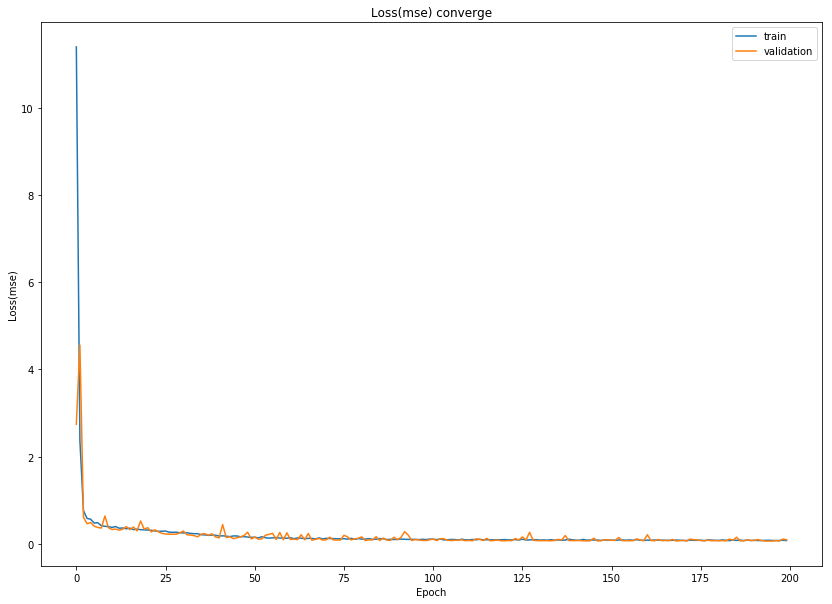

Wall time: 29min 8s


In [24]:
%time model_OTM, result_OTM = create_model(X_train_OTM, y_train_OTM)

,predicted,actual
0,0.278844,0.27
1,0.095971,0.12
2,0.242098,0.21
3,0.434230,0.50
4,0.065849,0.04
5,36.725391,37.45
6,0.315347,0.36
7,0.758837,0.84
8,0.480229,0.61
9,0.098753,0.07


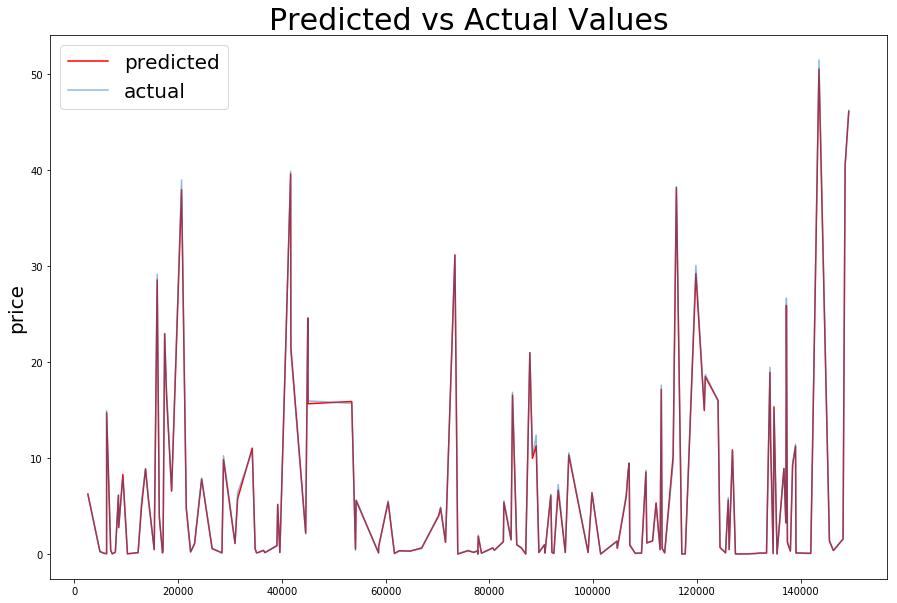

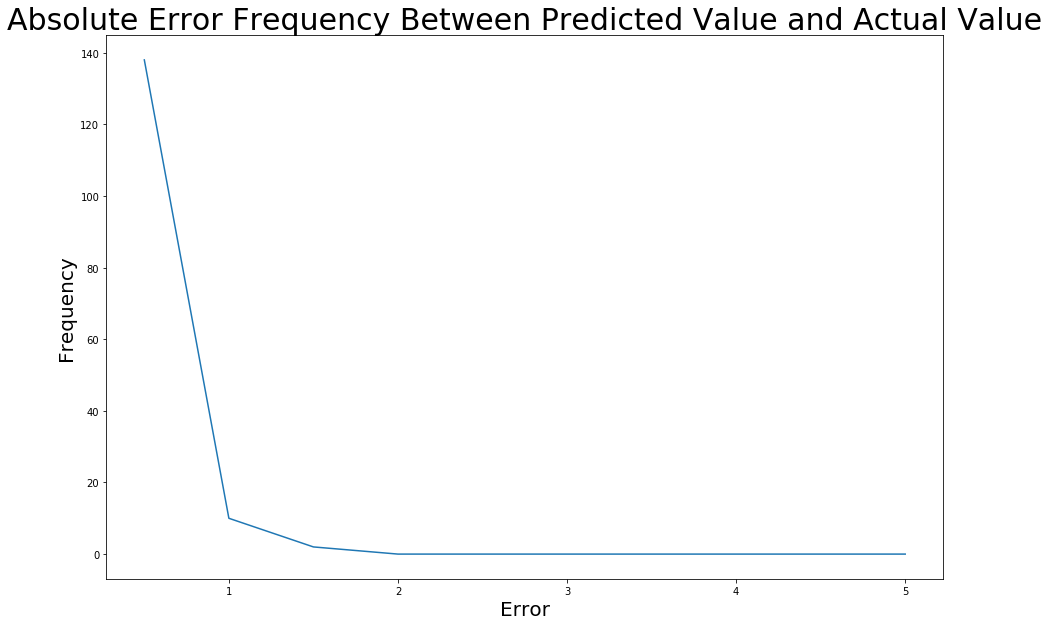

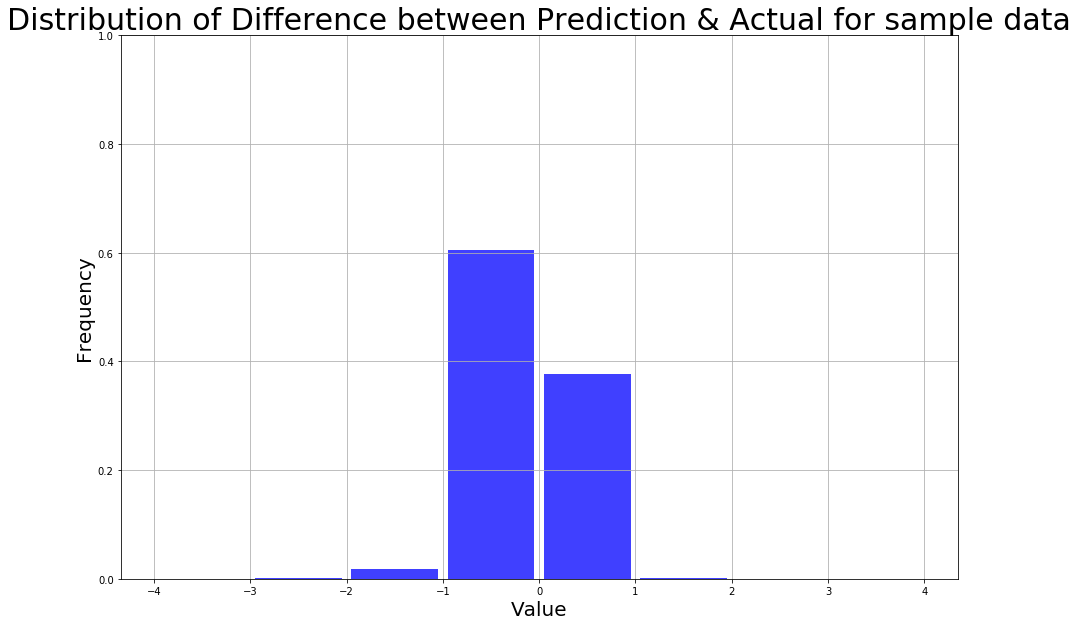



Mean absolute error (MAE): 0.160283
Mean squared error (MSE):  0.088955
R square (R^2):            0.999222


In [25]:

pred_OTM = pred(model_OTM, X_test_OTM, y_test_OTM)

In [26]:
model_OTM.save('model4_2_OTM_ori_abs.h5')

## Build model with whole data

In [17]:
X_train, X_test, y_train, y_test = data(sample_df.sample(frac = 0.7))

In [18]:
print(X_train[:10])
print(y_train[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
1533986       0.00         115.0            112.18        18         0.231628   
1480689       0.00         105.0             95.22        37         0.205385   
644579        0.00         250.0            166.45        22         0.611907   
601713        0.32          41.0             40.68        24         0.170103   
1626499      13.79          93.0            106.79        18         0.477880   
634677       21.10         185.0            163.90       716         0.216722   
523597        0.00          29.0             37.30       177         0.219712   
1097699       0.00          82.5             76.74        36         0.177693   
1001889       0.00          81.5             80.30        32         0.186932   
586135        0.00          34.0             41.84        35         0.311603   

         cp_flag_P  interest_rate  
1533986          0         0.0002  
1480689          0         0.0001  


W0827 15:30:10.573963  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 15:30:10.587973  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 15:30:10.590975  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 15:30:10.654039  9120 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 856917 samples, validate on 95214 samples
Epoch 1/200
856917/856917 [==============================] - 15s 18us/step - loss: 7.0594 - mean_absolute_error: 1.0441 - val_loss: 0.8492 - val_mean_absolute_error: 0.5970
Epoch 2/200
856917/856917 [==============================] - 16s 19us/step - loss: 0.6354 - mean_absolute_error: 0.4823 - val_loss: 0.7099 - val_mean_absolute_error: 0.5967
Epoch 3/200
856917/856917 [==============================] - 15s 18us/step - loss: 0.5253 - mean_absolute_error: 0.4340 - val_loss: 0.6225 - val_mean_absolute_error: 0.5049
Epoch 4/200
856917/856917 [==============================] - 15s 18us/step - loss: 0.4853 - mean_absolute_error: 0.4158 - val_loss: 0.5294 - val_mean_absolute_error: 0.4524
Epoch 5/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.4286 - mean_absolute_error: 0.3874 - val_loss: 0.5456 - val_mean_absolute_error: 0.4586
Epoch 6/200
856917/856917 [==============================] - 14s 17us/step - loss: 0

Epoch 48/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.1374 - mean_absolute_error: 0.2040 - val_loss: 0.0946 - val_mean_absolute_error: 0.1671
Epoch 49/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1390 - mean_absolute_error: 0.2045 - val_loss: 0.1828 - val_mean_absolute_error: 0.2563
Epoch 50/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1299 - mean_absolute_error: 0.1989 - val_loss: 0.0999 - val_mean_absolute_error: 0.1721
Epoch 51/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1321 - mean_absolute_error: 0.2011 - val_loss: 0.1248 - val_mean_absolute_error: 0.2031
Epoch 52/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1314 - mean_absolute_error: 0.1998 - val_loss: 0.1473 - val_mean_absolute_error: 0.2293
Epoch 53/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1272 - mean_absolute_error: 0.1969 - val_los

Epoch 142/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0850 - mean_absolute_error: 0.1600 - val_loss: 0.0878 - val_mean_absolute_error: 0.1644
Epoch 143/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.0906 - mean_absolute_error: 0.1654 - val_loss: 0.0894 - val_mean_absolute_error: 0.1749
Epoch 144/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0853 - mean_absolute_error: 0.1610 - val_loss: 0.0927 - val_mean_absolute_error: 0.1723
Epoch 145/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0894 - mean_absolute_error: 0.1649 - val_loss: 0.0877 - val_mean_absolute_error: 0.1673
Epoch 146/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0890 - mean_absolute_error: 0.1634 - val_loss: 0.0813 - val_mean_absolute_error: 0.1607
Epoch 147/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.0912 - mean_absolute_error: 0.1658 - v

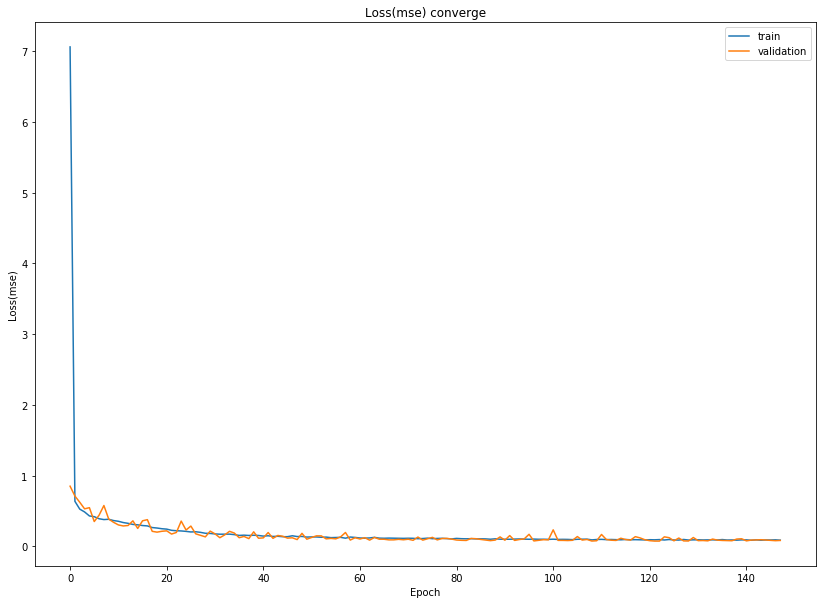

Wall time: 36min 16s


In [19]:
%time model, result = create_model(X_train, y_train)

,predicted,actual
0,16.085932,15.60
1,0.011209,0.03
2,6.017977,6.00
3,0.128381,0.09
4,11.799656,12.05
5,23.282141,23.05
6,11.068350,11.00
7,0.149090,0.13
8,0.212410,0.22
9,1.534832,1.46


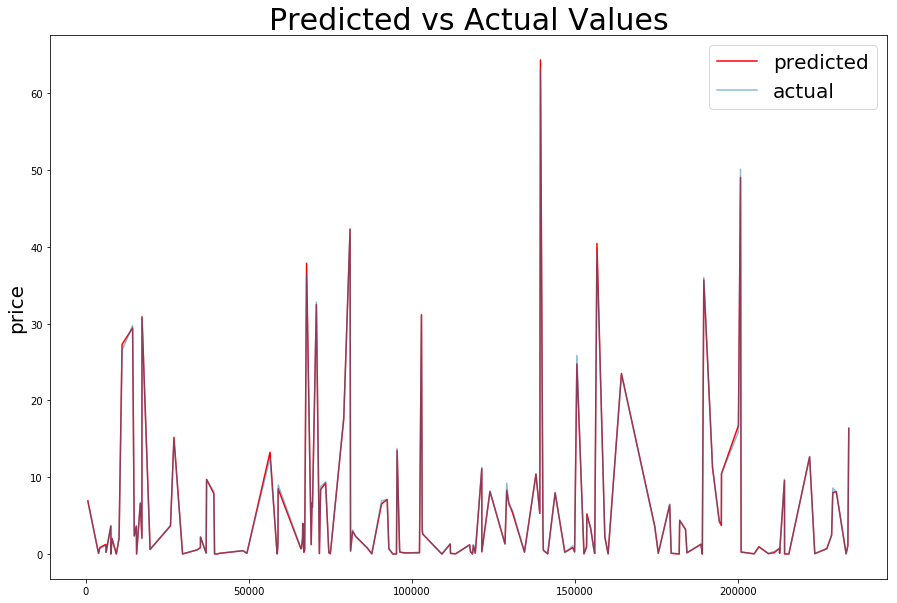

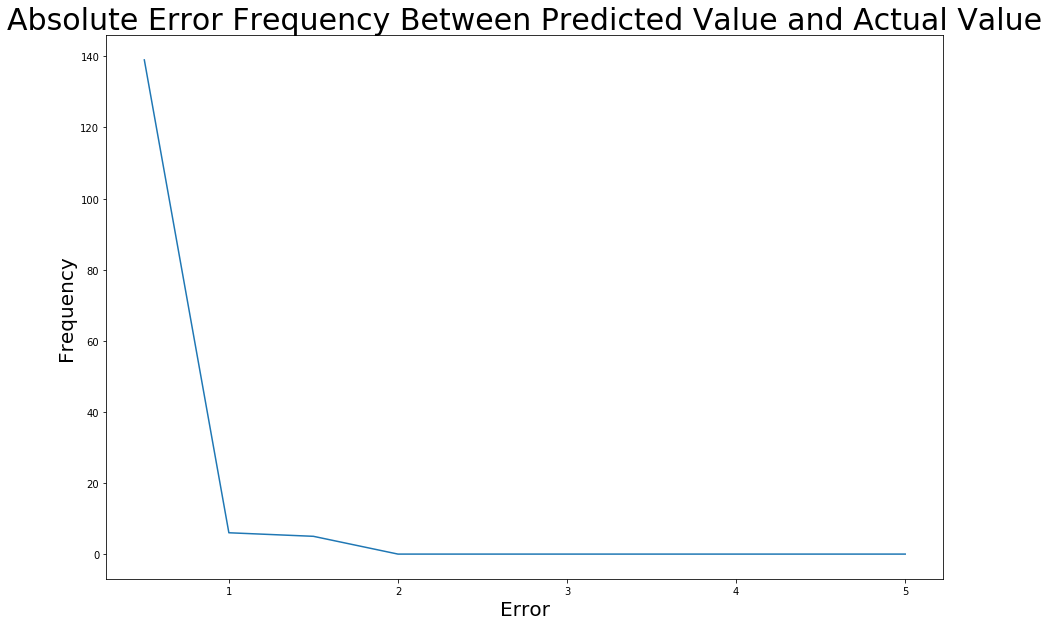

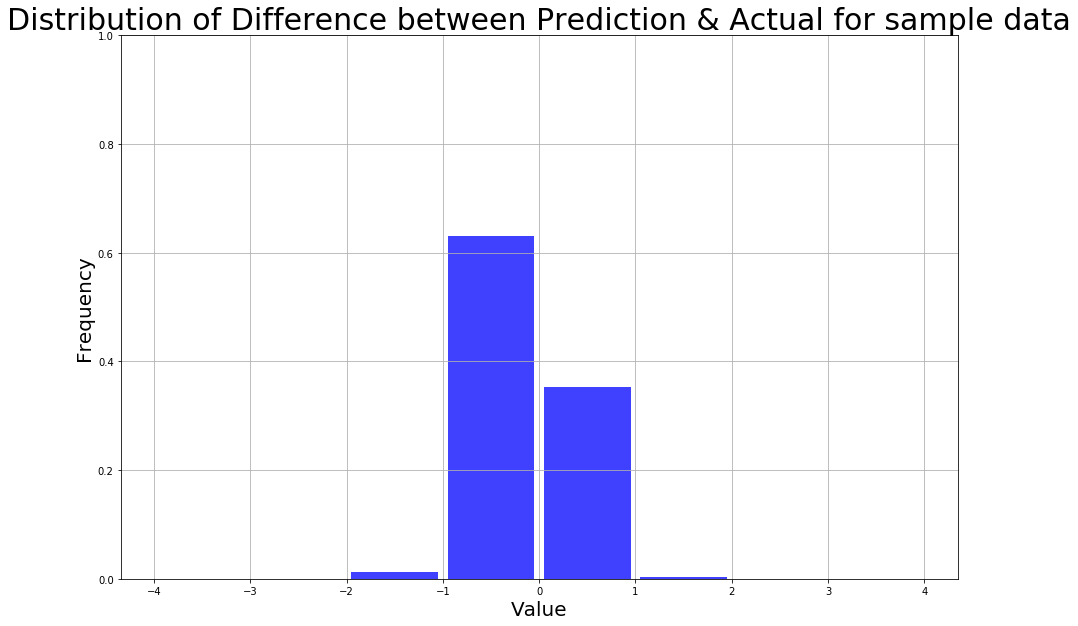



Mean absolute error (MAE): 0.157615
Mean squared error (MSE):  0.082861
R square (R^2):            0.999430


In [20]:
pred_whole = pred(model, X_test, y_test)

In [21]:
model.save('model4_2_whole_ori_abs.h5')

# Prediction

We use the three models we built above to do option price prediction. In the above, the train and test dataset were generated from the same dataset, even though they were splited randomly, the data structures were very similar. In this section, we want to apply the models to out of sample data which is in different time range from the data used to train the model to check our models' robustness. 

In [22]:
def load_prediction_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    ITM_df = df[df['moneyness'] <= 0.97]
    ATM_df = df[df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = df[df['moneyness'] >= 1.03]
    
    return df, ITM_df, ATM_df, OTM_df

In [23]:
p_df, p_df_ITM, p_df_ATM, p_df_OTM = load_prediction_data()

In [52]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.transform(X)

#     sc_y = StandardScaler()
#     y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X)
    
    pred = pred.flatten()
#     y_scale = y_scale.flatten()
    y = y.flatten()
#     y_pred = sc_y.inverse_transform(pred)
    
    d = {'predict': pred, 'actual':y}
    datanew = pd.DataFrame(data = d)
    display(datanew.head(10))
      
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
     #Line graph for sample data
    plt.figure(1, figsize = (15,10))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    #Absolute error
    l,binEdges=np.histogram(np.abs(sample_data['predict']-sample_data['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
     
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist((datanew['predict']-datanew['actual']), 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    

    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, pred))
    #print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, y_pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, pred))

## Predict in-the-money option data

In [54]:
model_ITM = load_model('model4_2_ITM_ori_abs.h5', custom_objects={'ABS':ABS})

,predict,actual
0,1.008936,0.13
1,1.027718,0.13
2,0.190681,0.06
3,0.145375,0.04
4,0.105349,0.03
5,0.066919,0.03
6,0.077406,0.03
7,0.056596,0.02
8,0.122258,0.06
9,0.122089,0.05


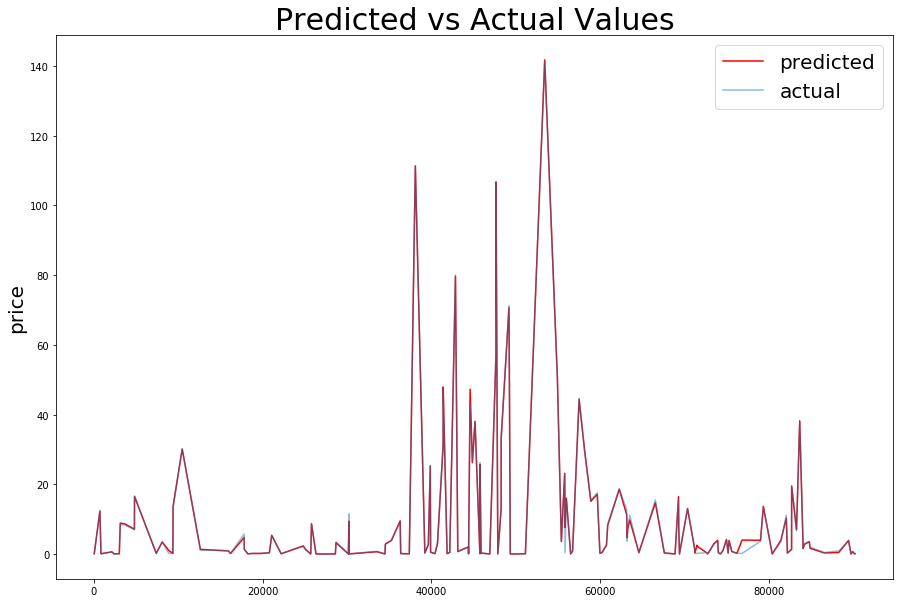

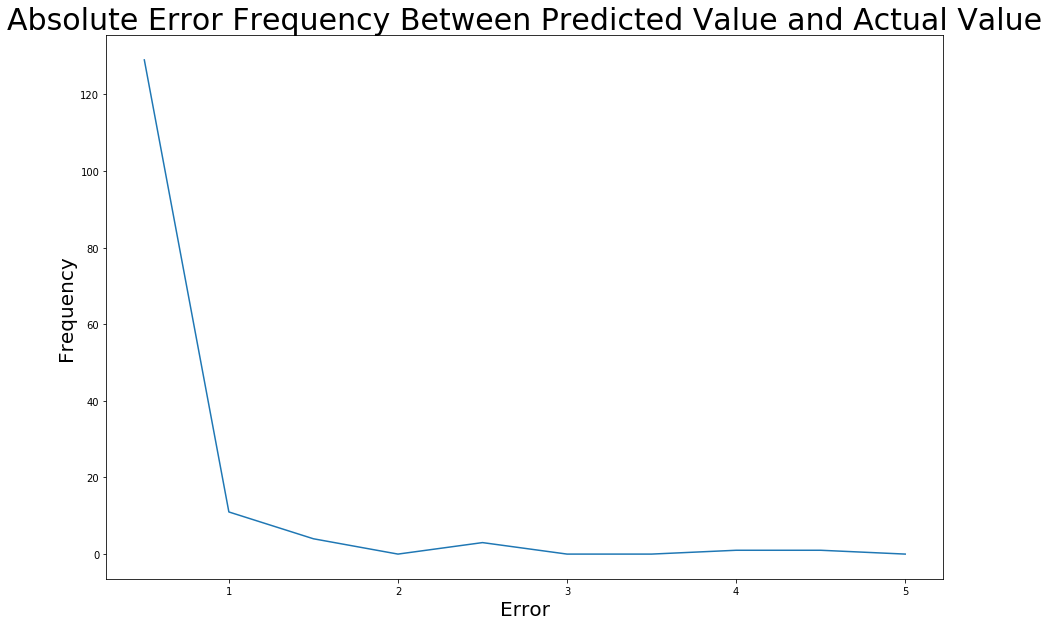

Mean absolute error (MAE):      0.291723
Mean squared error (MSE):       0.362842
R square (R^2):                 0.998886


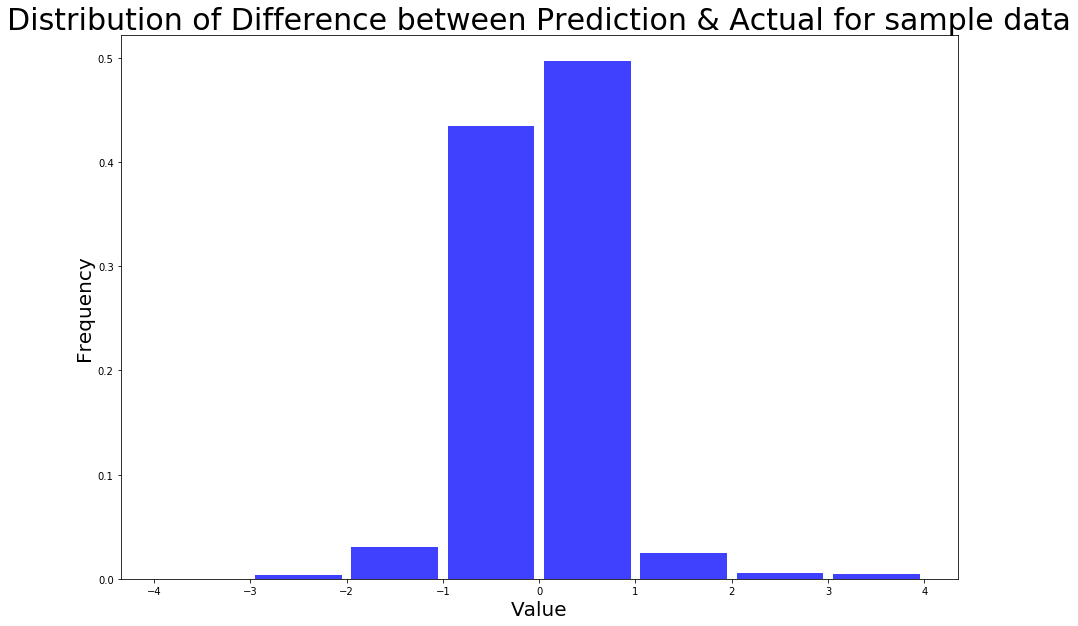

In [55]:
model_pred(p_df_ITM, model_ITM, 'impl_volatility')

,predict,actual
0,0.958661,0.13
1,0.966770,0.13
2,0.135594,0.06
3,0.083517,0.04
4,0.044853,0.03
5,0.051965,0.03
6,0.061806,0.03
7,0.079410,0.02
8,0.094539,0.06
9,0.125554,0.05


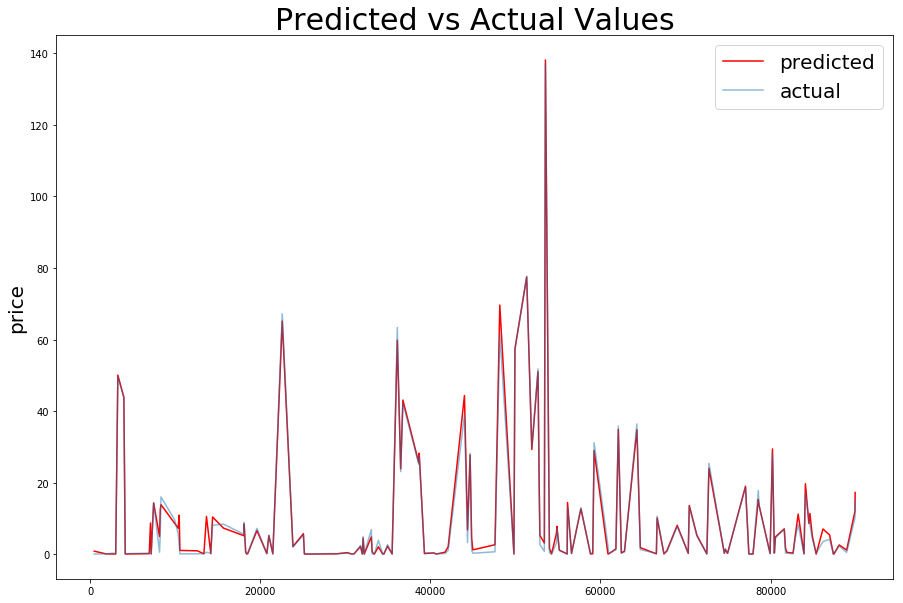

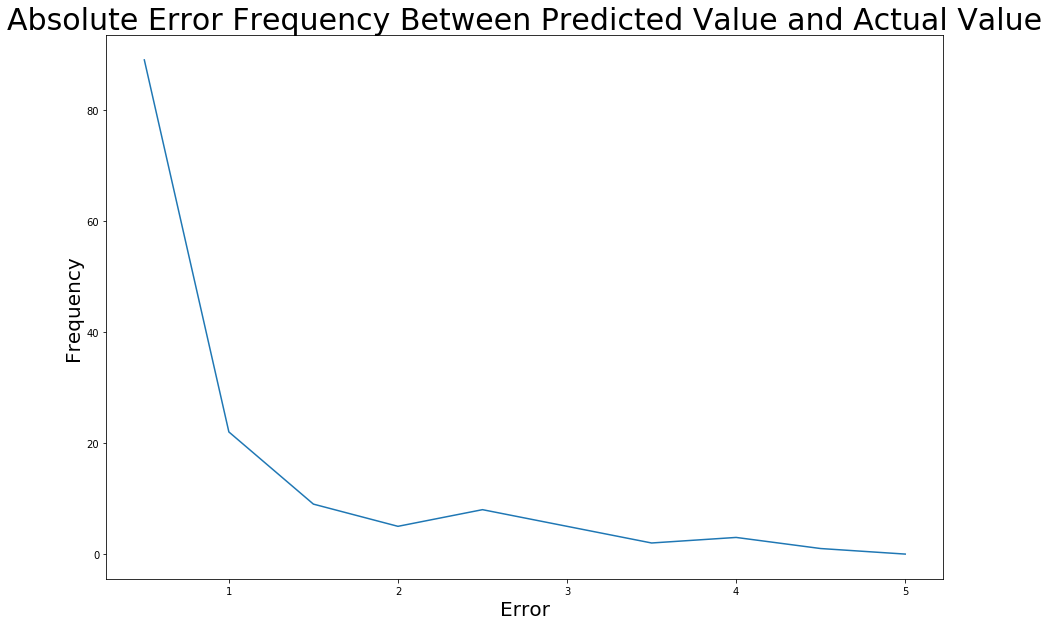

Mean absolute error (MAE):      0.776917
Mean squared error (MSE):       1.994713
R square (R^2):                 0.993875


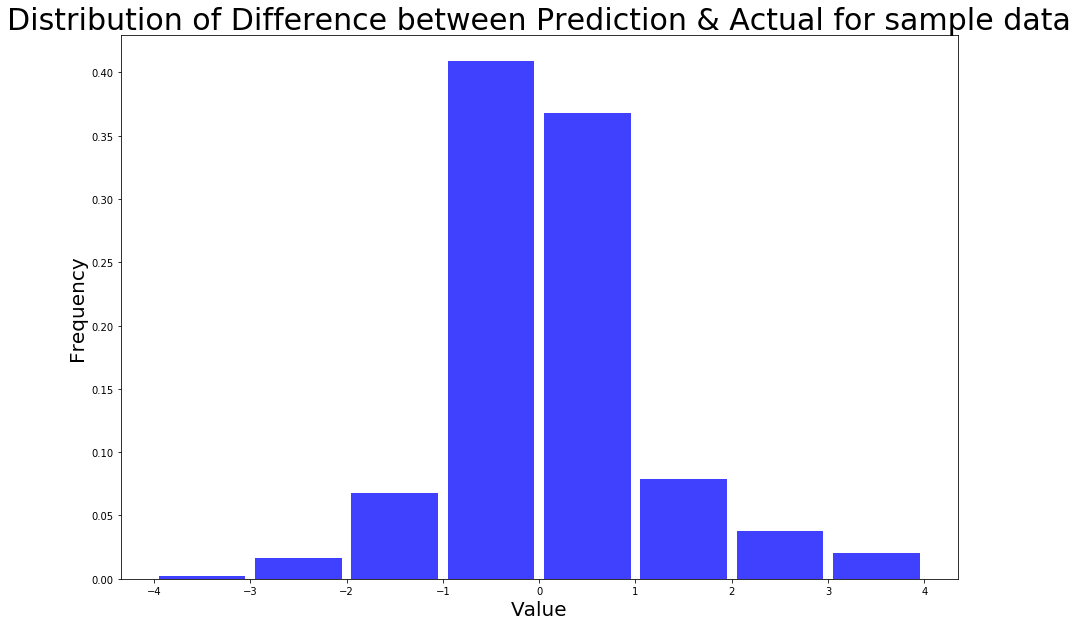

In [56]:

model_pred(p_df_ITM, model_ITM, 'realized_vol')

## Predict at-the-money option data

In [58]:
model_ATM = load_model('model4_2_ATM_ori_abs.h5', custom_objects={'ABS':ABS})

,predict,actual
0,1.960426,1.70
1,1.638741,1.31
2,1.327547,0.95
3,0.964332,0.66
4,0.691687,0.44
5,0.537887,0.28
6,0.427261,0.17
7,0.340126,0.10
8,0.507888,0.34
9,0.621592,0.48


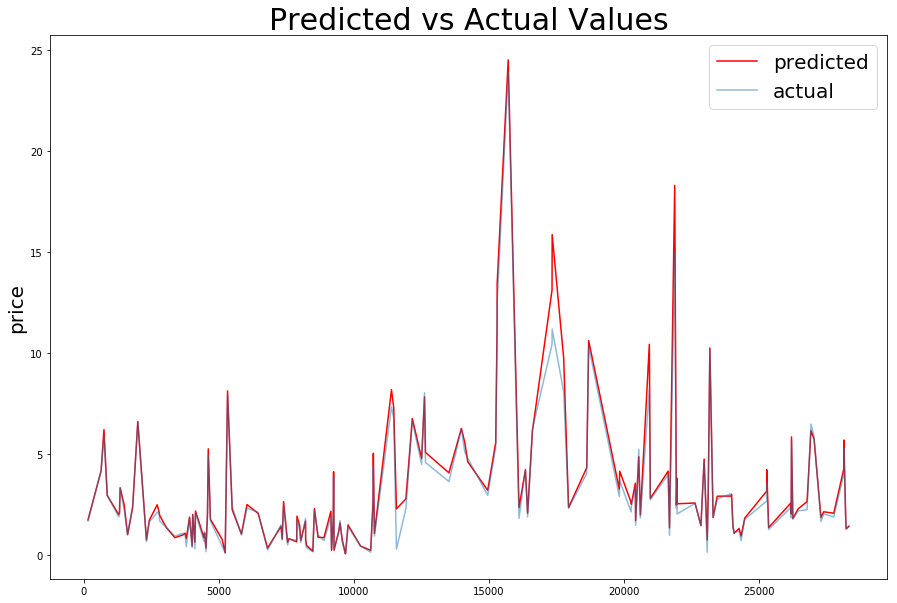

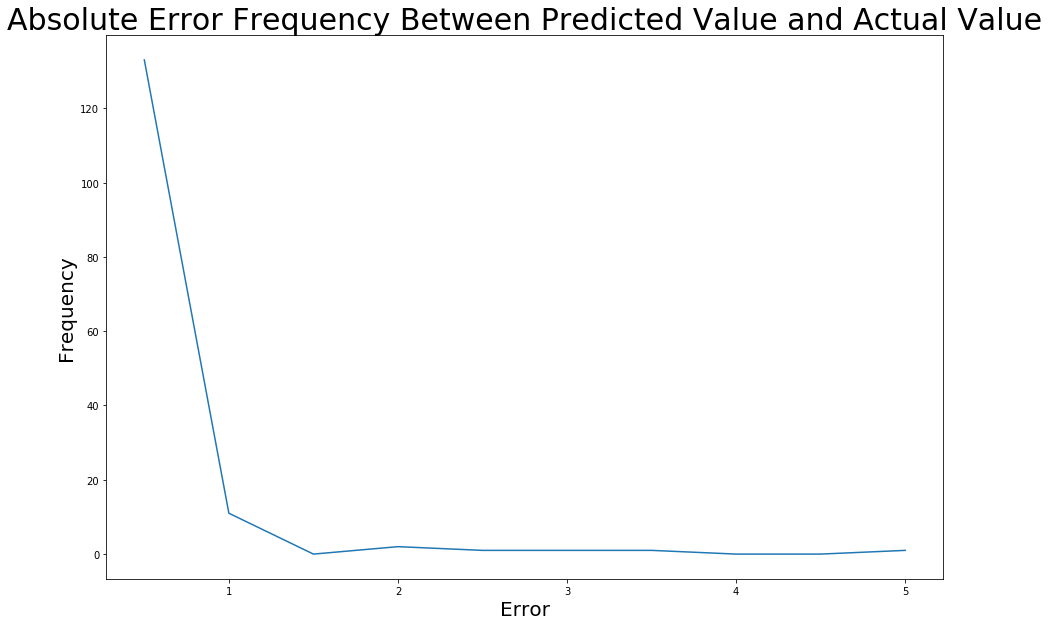

Mean absolute error (MAE):      0.278638
Mean squared error (MSE):       0.284329
R square (R^2):                 0.974941


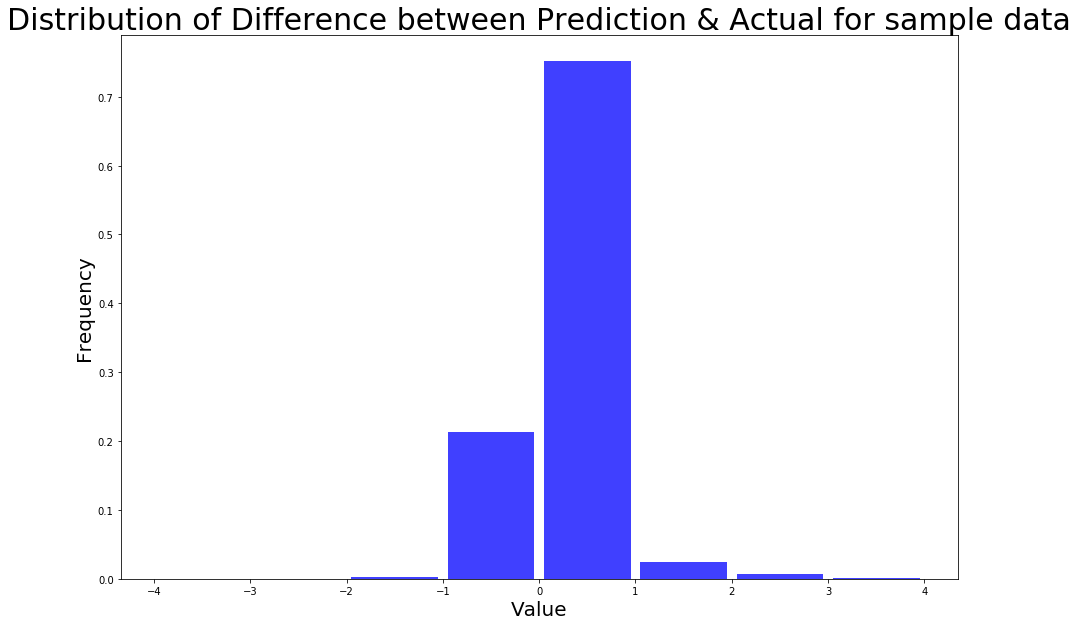

In [59]:
model_pred(p_df_ATM, model_ATM, 'impl_volatility')

,predict,actual
0,1.844988,1.70
1,1.548128,1.31
2,1.208208,0.95
3,0.836784,0.66
4,0.580941,0.44
5,0.394563,0.28
6,0.298981,0.17
7,0.226590,0.10
8,0.189377,0.34
9,0.330261,0.48


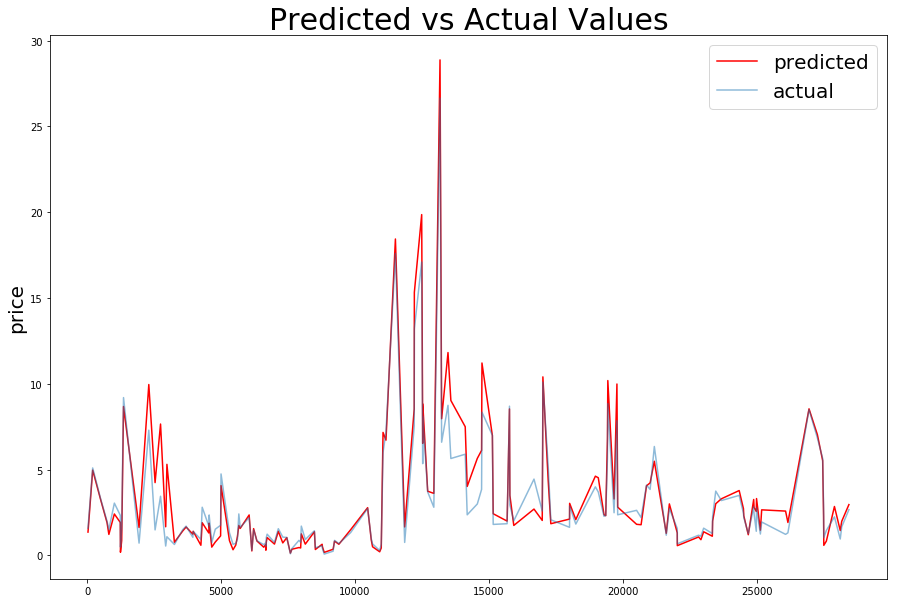

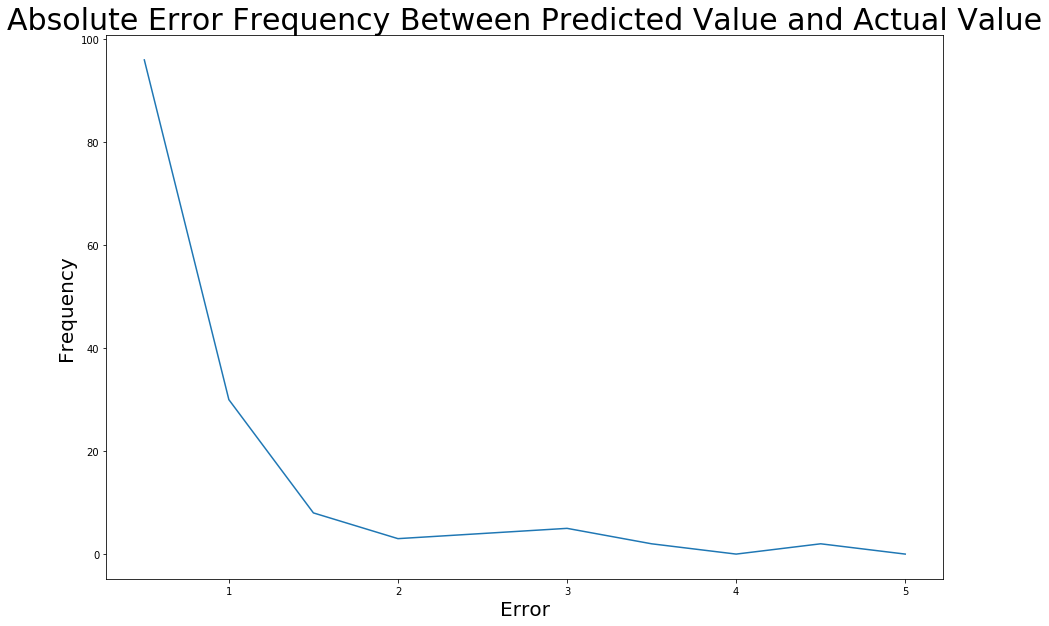

Mean absolute error (MAE):      0.706204
Mean squared error (MSE):       1.305062
R square (R^2):                 0.884978


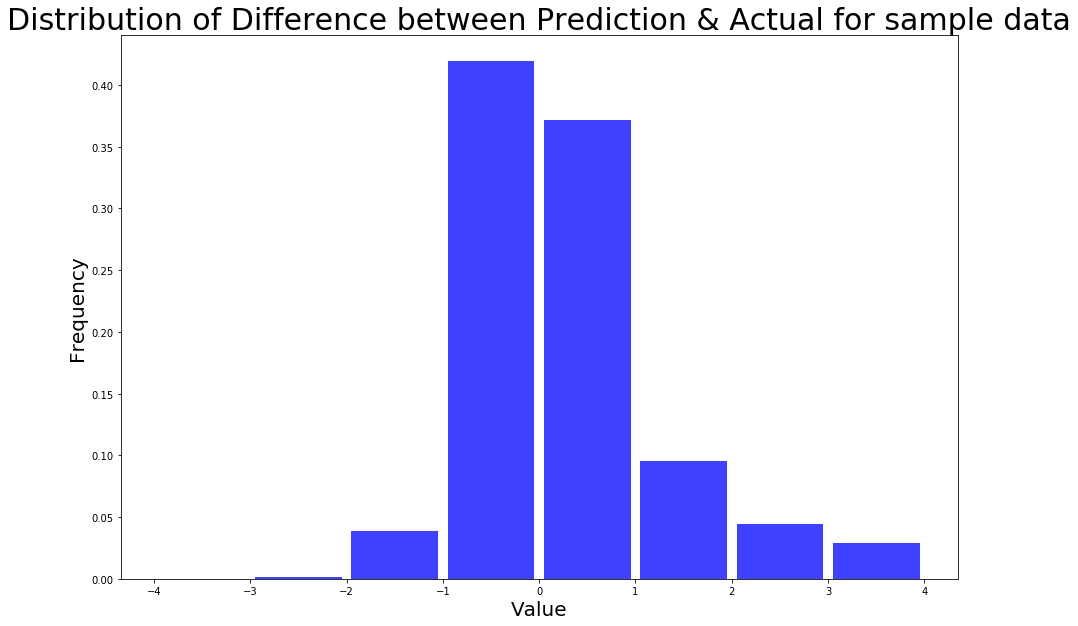

In [60]:
model_pred(p_df_ATM, model_ATM, 'realized_vol')

## Predict out-the-money option data

In [61]:
model_OTM = load_model('model4_2_OTM_ori_abs.h5', custom_objects={'ABS':ABS})

,predict,actual
0,0.384572,0.14
1,0.351530,0.13
2,0.307940,0.12
3,0.124869,0.06
4,0.056594,0.02
5,0.072349,0.04
6,0.079213,0.05
7,0.083094,0.06
8,0.097895,0.08
9,0.117650,0.10


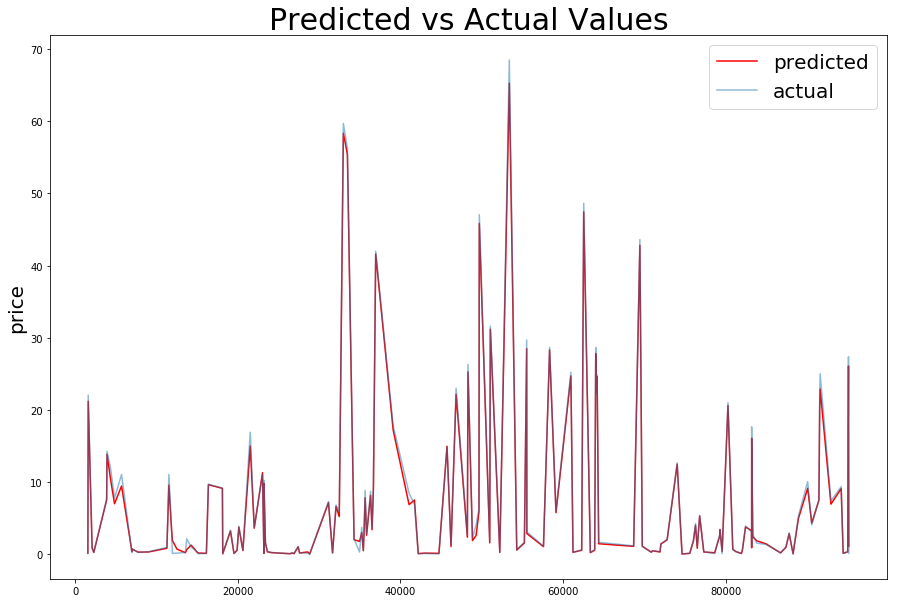

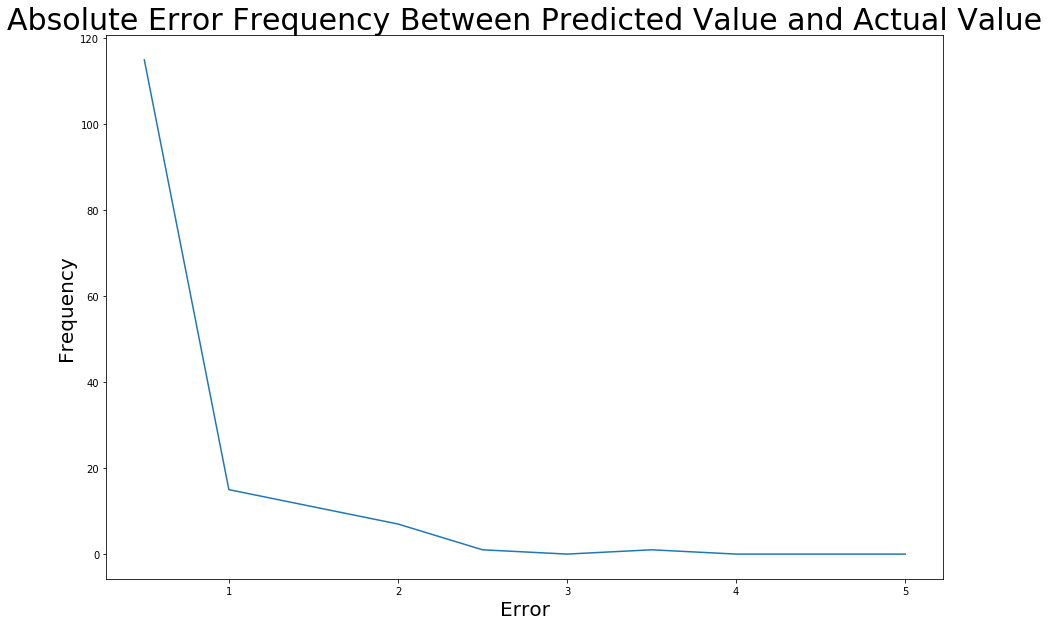

Mean absolute error (MAE):      0.364350
Mean squared error (MSE):       0.472662
R square (R^2):                 0.997323


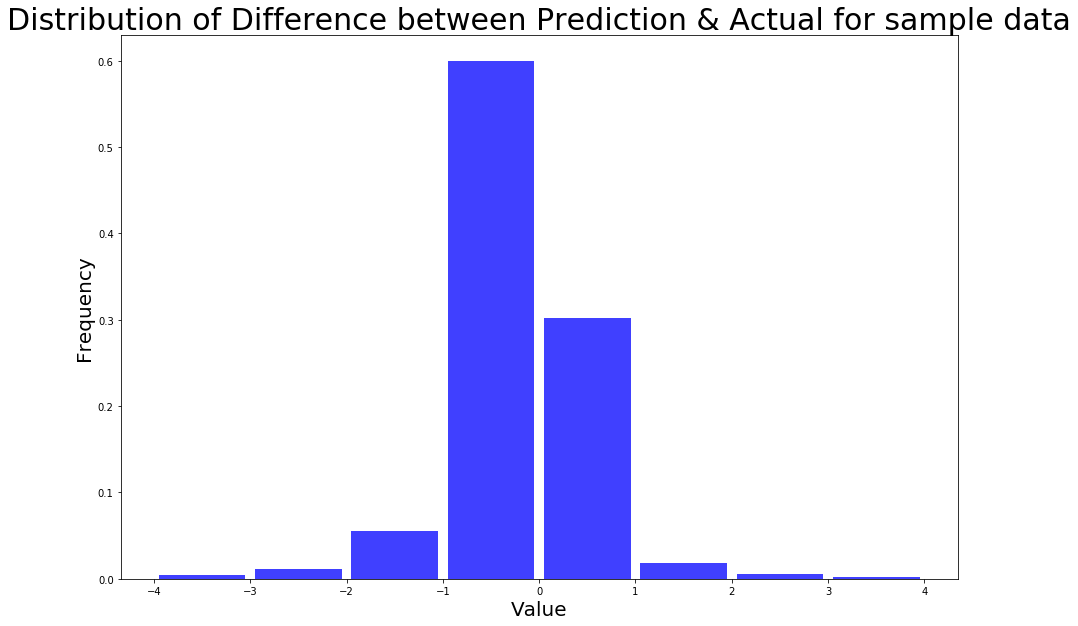

In [62]:
model_pred(p_df_OTM, model_OTM, 'impl_volatility')

,predict,actual
0,0.683353,0.14
1,0.634841,0.13
2,0.465266,0.12
3,0.287445,0.06
4,0.220075,0.02
5,0.173982,0.04
6,0.140968,0.05
7,0.101266,0.06
8,0.054975,0.08
9,0.029775,0.10


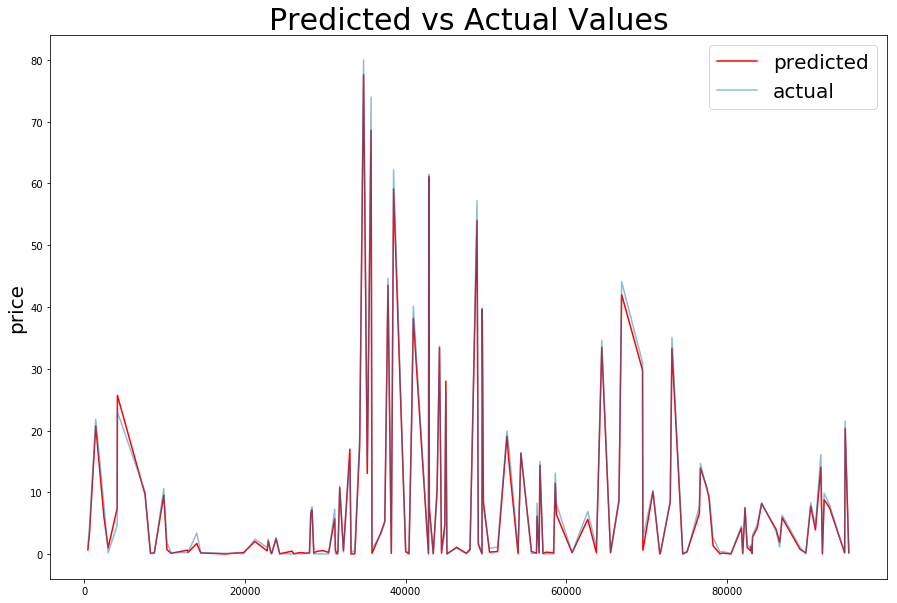

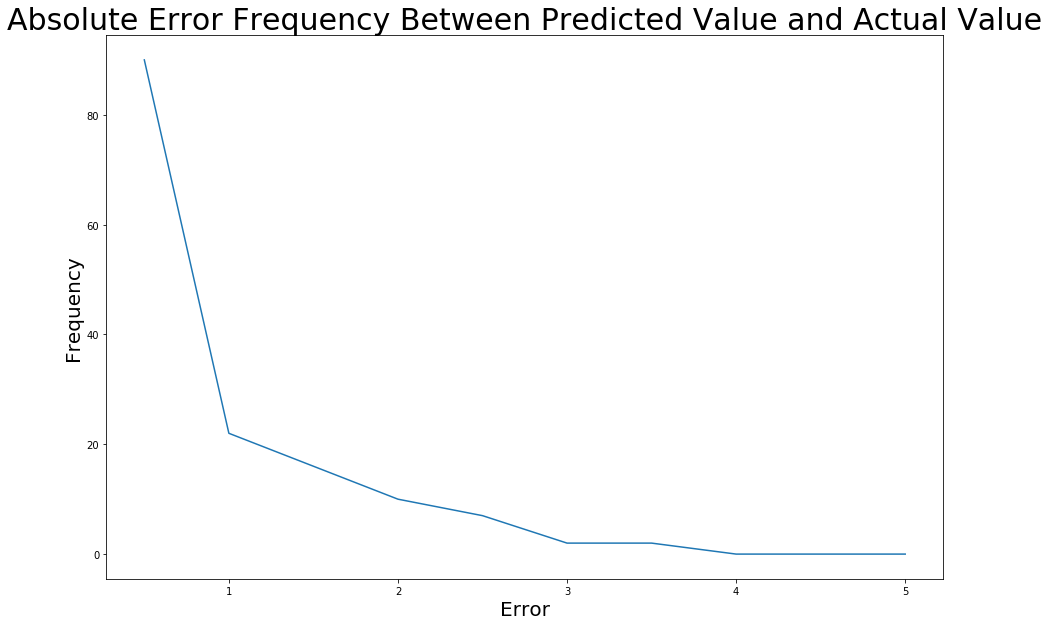

Mean absolute error (MAE):      0.703258
Mean squared error (MSE):       1.328165
R square (R^2):                 0.992479


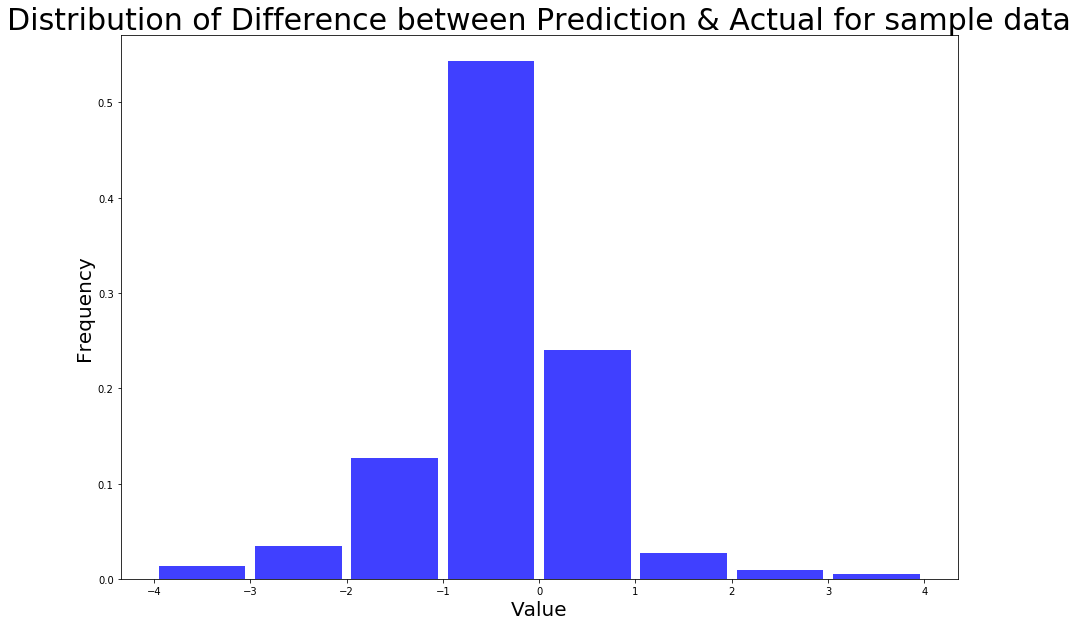

In [63]:
model_pred(p_df_OTM, model_OTM, 'realized_vol')

## Predict whole option data

In [64]:
model = load_model('model4_2_whole_ori_abs.h5', custom_objects={'ABS':ABS})

,predict,actual
0,0.821605,0.13
1,0.834150,0.13
2,1.883730,1.70
3,1.494152,1.31
4,1.141863,0.95
5,0.923988,0.66
6,0.679957,0.44
7,0.512487,0.28
8,0.354058,0.17
9,0.215539,0.10


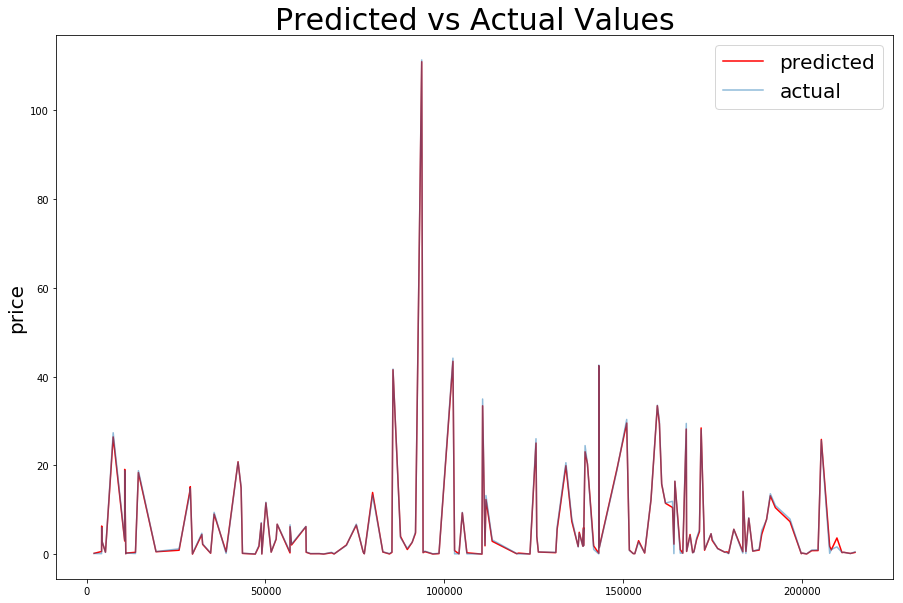

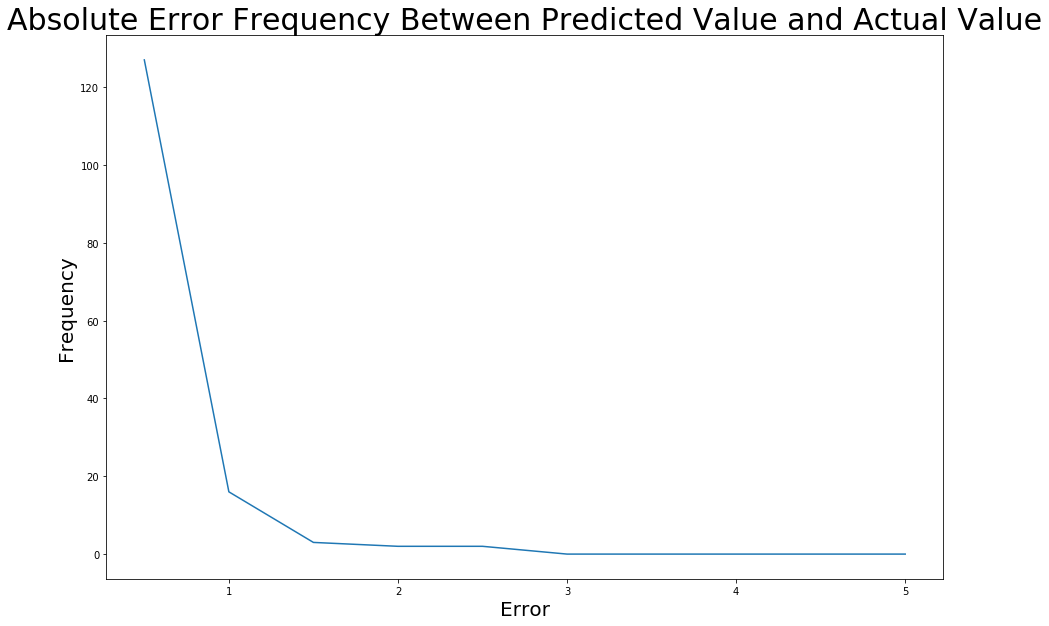

Mean absolute error (MAE):      0.289064
Mean squared error (MSE):       0.295878
R square (R^2):                 0.998661


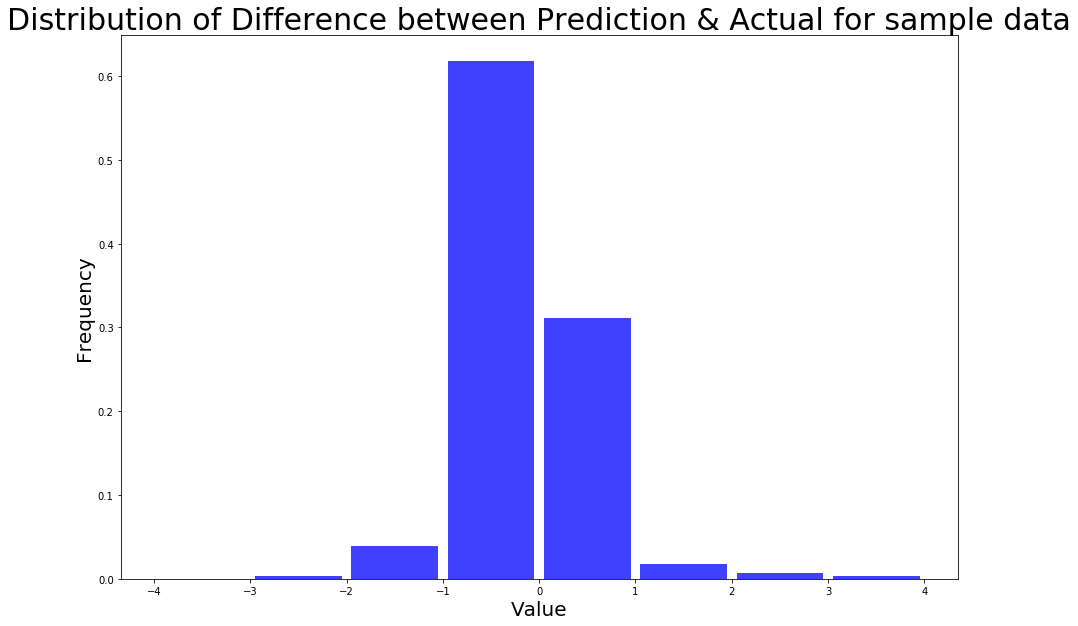

In [65]:
model_pred(p_df, model, 'impl_volatility')

,predict,actual
0,0.282078,0.13
1,0.222915,0.13
2,1.749915,1.70
3,1.356996,1.31
4,1.052673,0.95
5,0.726403,0.66
6,0.489545,0.44
7,0.328806,0.28
8,0.227577,0.17
9,0.141387,0.10


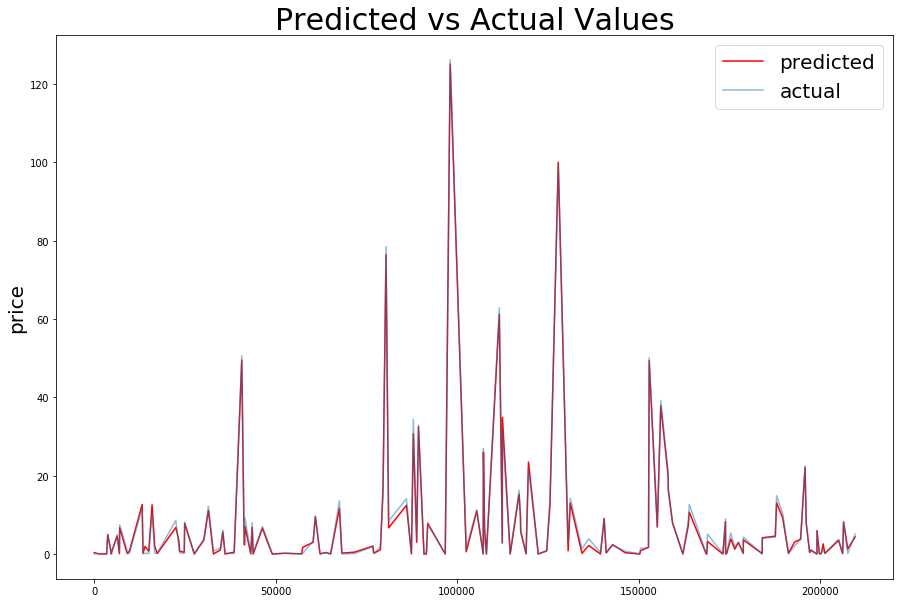

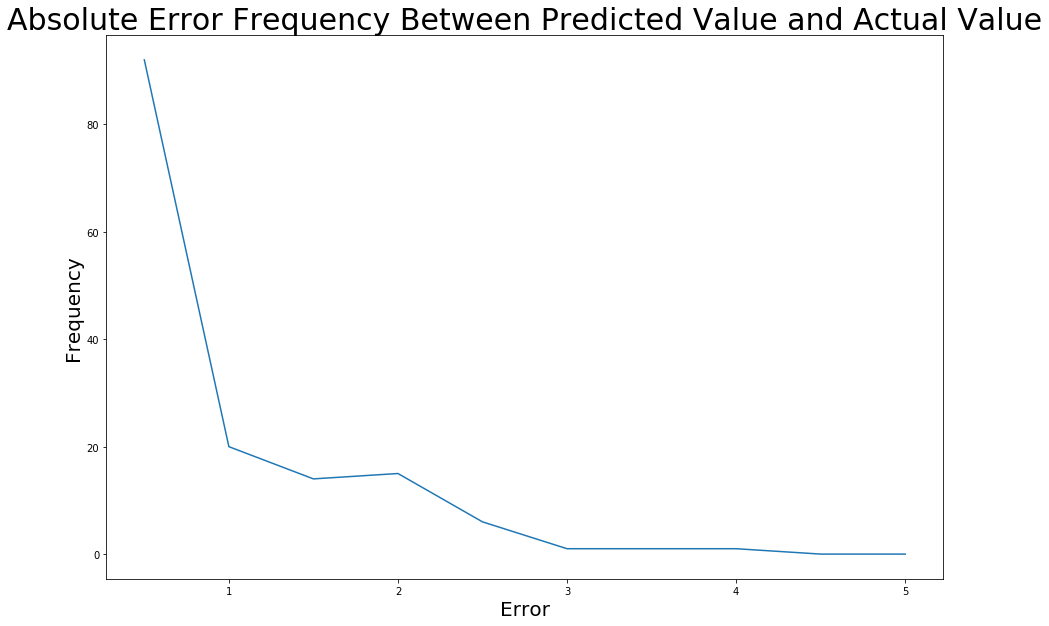

Mean absolute error (MAE):      0.680957
Mean squared error (MSE):       1.144921
R square (R^2):                 0.994820


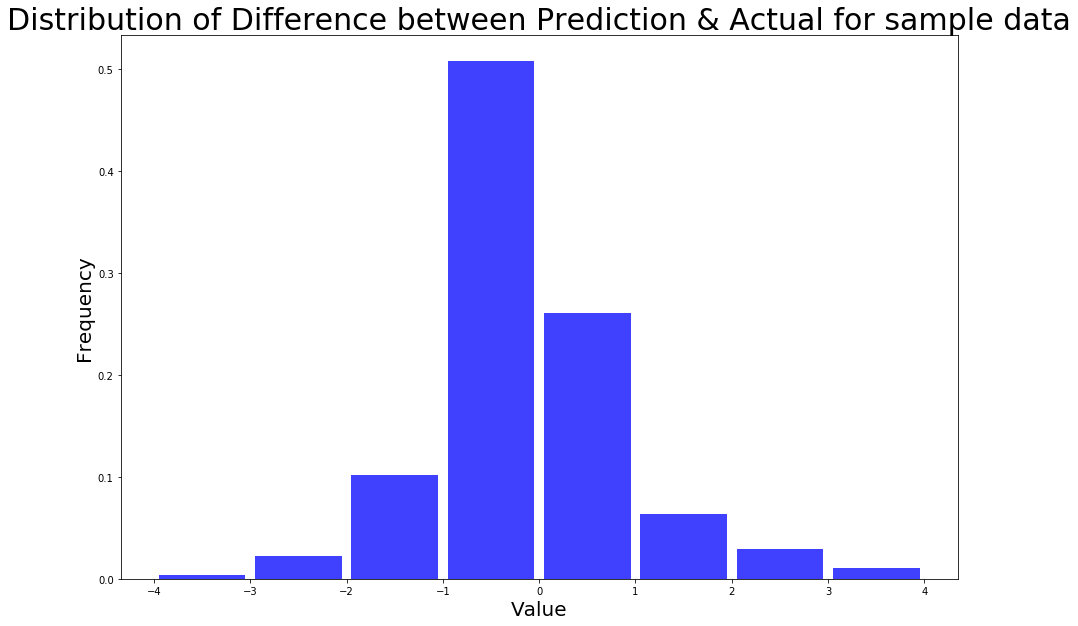

In [66]:
model_pred(p_df, model, 'realized_vol')

In [67]:
def load_AAPL():
    AAPL = pd.read_csv('Options2016AAPL_withReaVo.csv')
    AAPL = AAPL.dropna()
    AAPL.rename(columns = {'Strike Price':'strike_price', 'Lowest  Closing Ask Across All Exchanges':'best_offer', 
                           'Underlying Price':'underlying_price', 'C=Call, P=Put_C':'cp_flag_C', 'C=Call, P=Put_P':'cp_flag_P',
                           'volatility':'realized_vol'}, inplace = True);
    AAPL['intrinsic'] = AAPL.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], 
                                                         row['cp_flag_P']), axis = 1)
    AAPL['moneyness'] = AAPL.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    ITM_df = AAPL[AAPL['moneyness'] <= 0.97]
    ATM_df = AAPL[AAPL['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = AAPL[AAPL['moneyness'] >= 1.03]
    
    return AAPL, ITM_df, ATM_df, OTM_df

In [68]:
AAPL, AAPL_ITM, AAPL_ATM, AAPL_OTM = load_AAPL()

,predict,actual
0,0.186619,0.18
1,0.102068,0.10
2,0.045049,0.06
3,0.050552,0.04
4,0.066149,0.03
5,0.081723,0.03
6,0.107226,0.02
7,0.138048,0.02
8,0.150936,0.02
9,0.193314,0.02


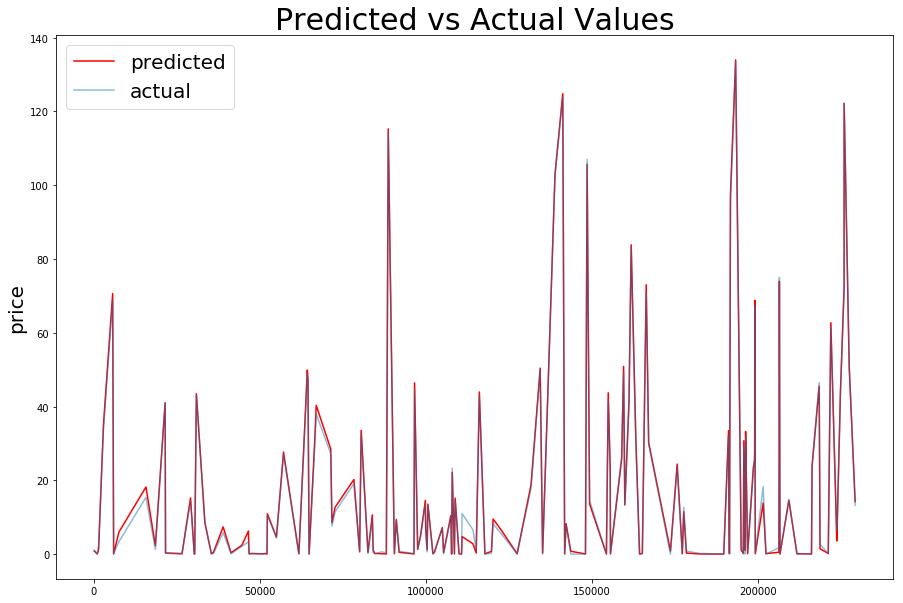

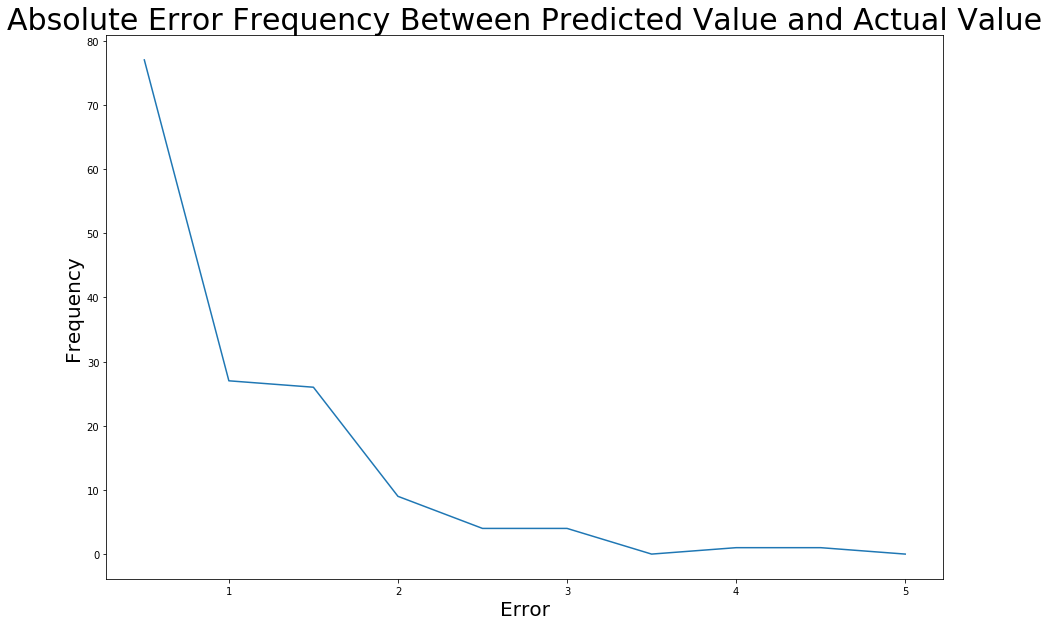

Mean absolute error (MAE):      0.773878
Mean squared error (MSE):       1.409658
R square (R^2):                 0.997995


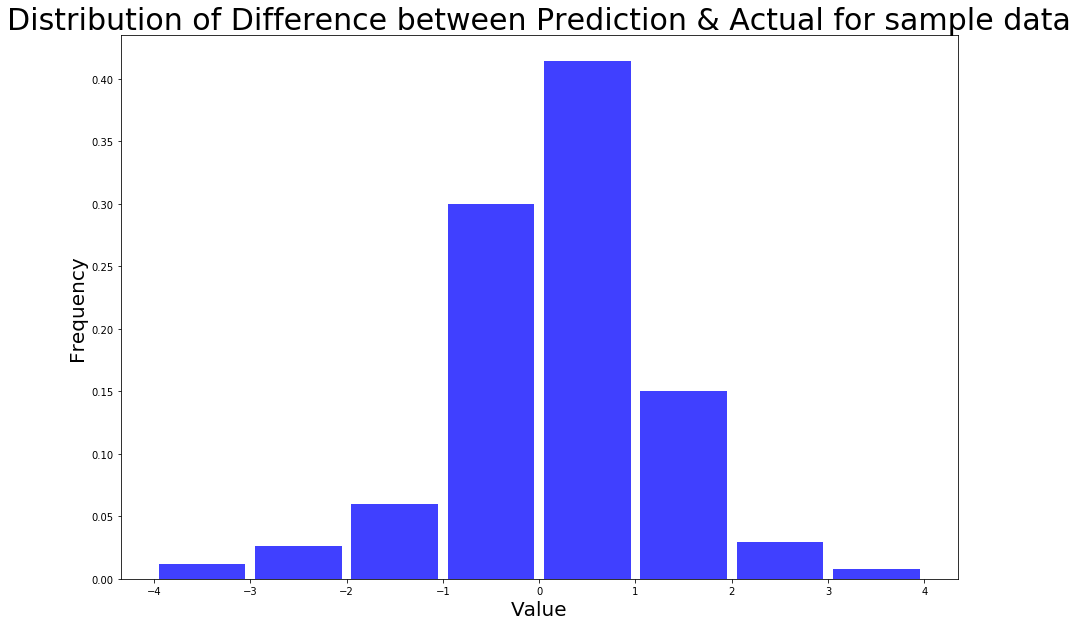

In [69]:
model_pred(AAPL_ITM, model_ITM, 'realized_vol')

,predict,actual
0,2.983442,2.79
1,2.214026,2.06
2,1.562206,1.43
3,1.010525,0.93
4,0.626940,0.56
5,0.391274,0.32
6,0.476331,0.61
7,0.788288,0.88
8,1.253294,1.25
9,1.802456,1.76


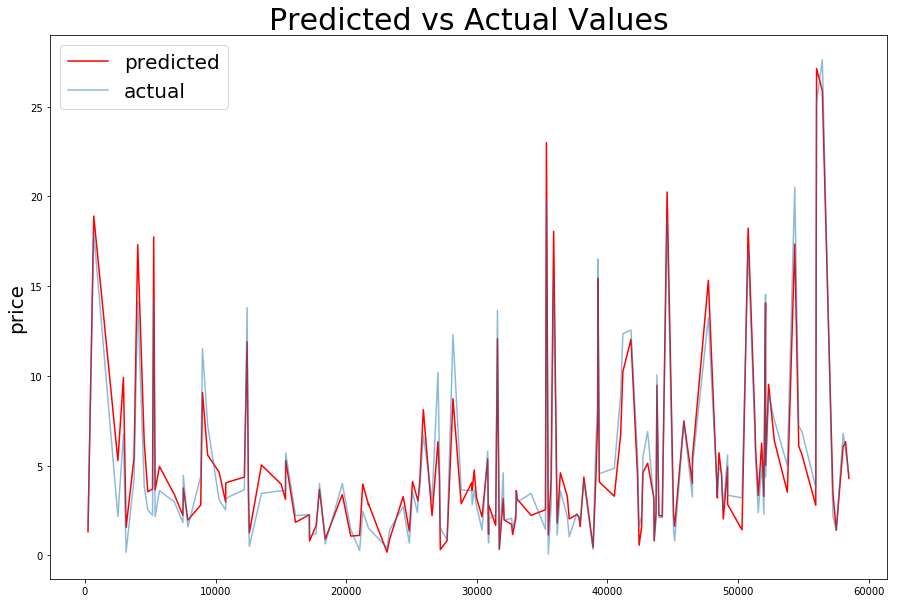

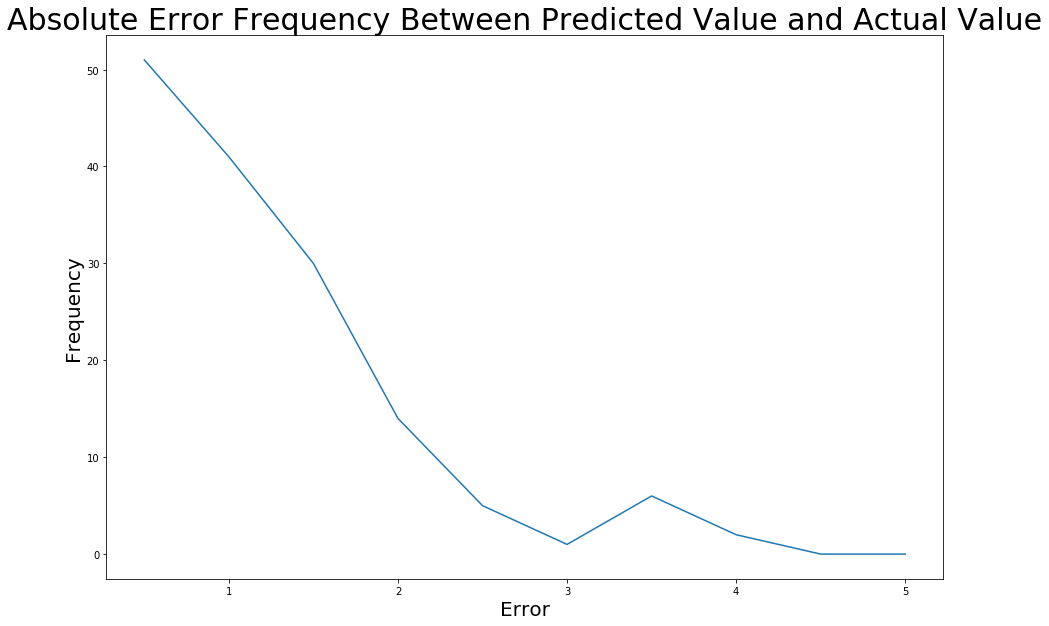

Mean absolute error (MAE):      0.931870
Mean squared error (MSE):       1.498989
R square (R^2):                 0.914542


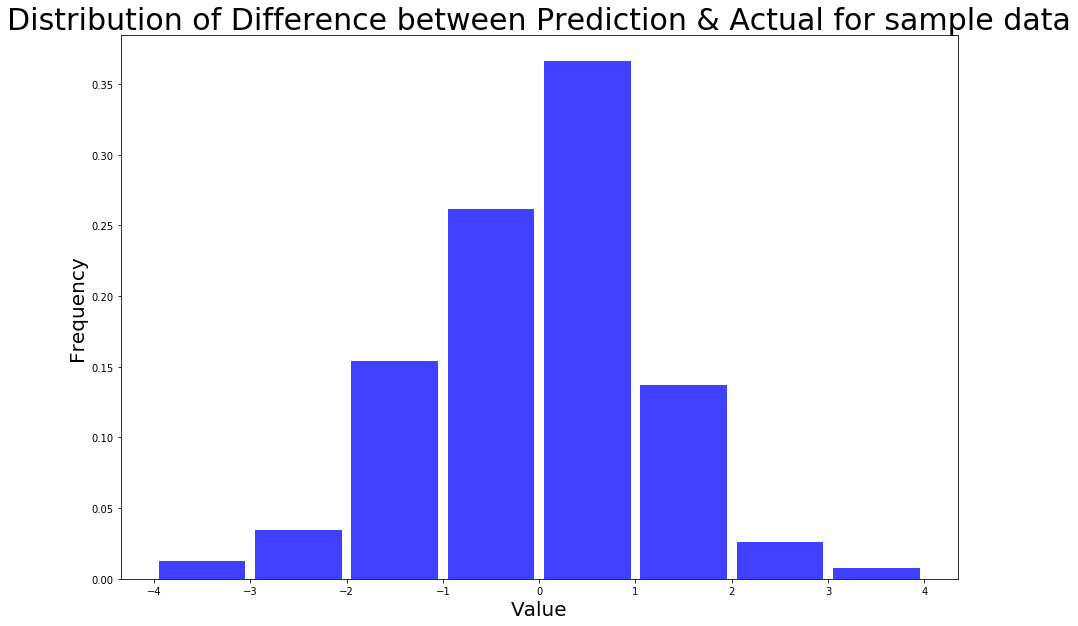

In [70]:
model_pred(AAPL_ATM, model_ATM, 'realized_vol')

,predict,actual
0,5.427134,5.45
1,4.458620,4.50
2,3.522616,3.65
3,6.416287,6.45
4,0.032718,0.23
5,0.073368,0.31
6,0.131967,0.43
7,1.055835,0.02
8,1.085351,0.02
9,0.808884,0.02


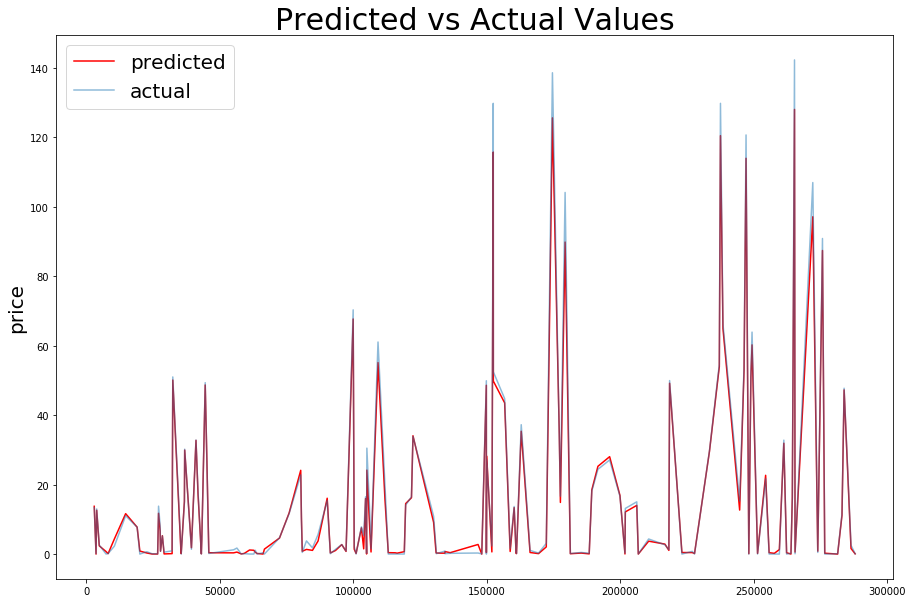

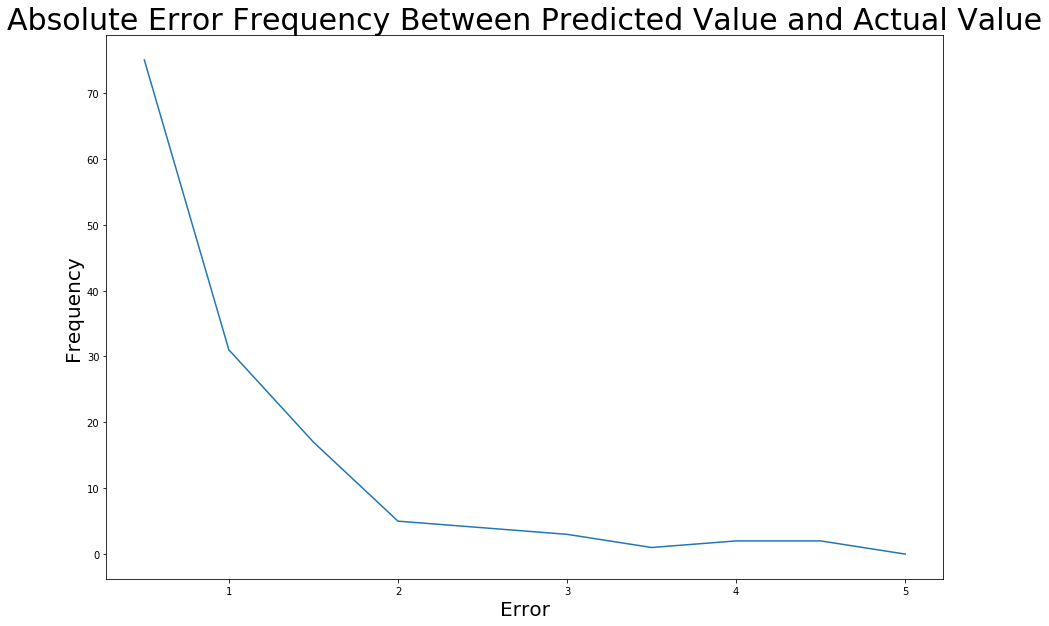

Mean absolute error (MAE):      1.221469
Mean squared error (MSE):       6.327207
R square (R^2):                 0.990203


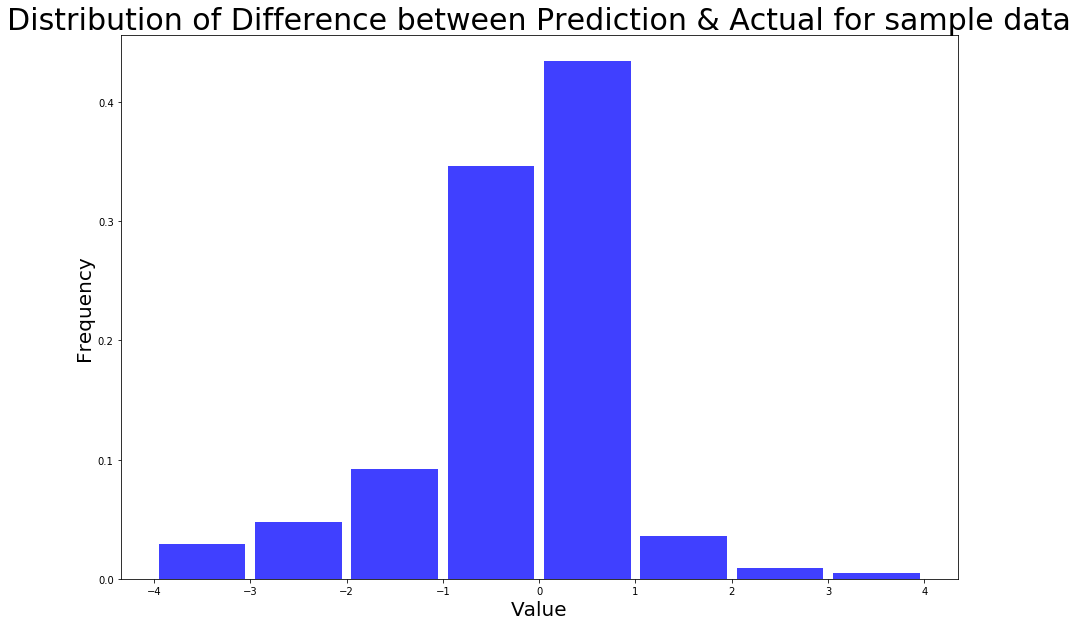

In [71]:
model_pred(AAPL_OTM, model_OTM, 'realized_vol')

,predict,actual
0,5.455711,5.45
1,4.497290,4.50
2,3.584838,3.65
3,2.797225,2.79
4,2.008213,2.06
5,1.238898,1.43
6,0.677298,0.93
7,0.418232,0.56
8,0.258916,0.32
9,0.116753,0.18


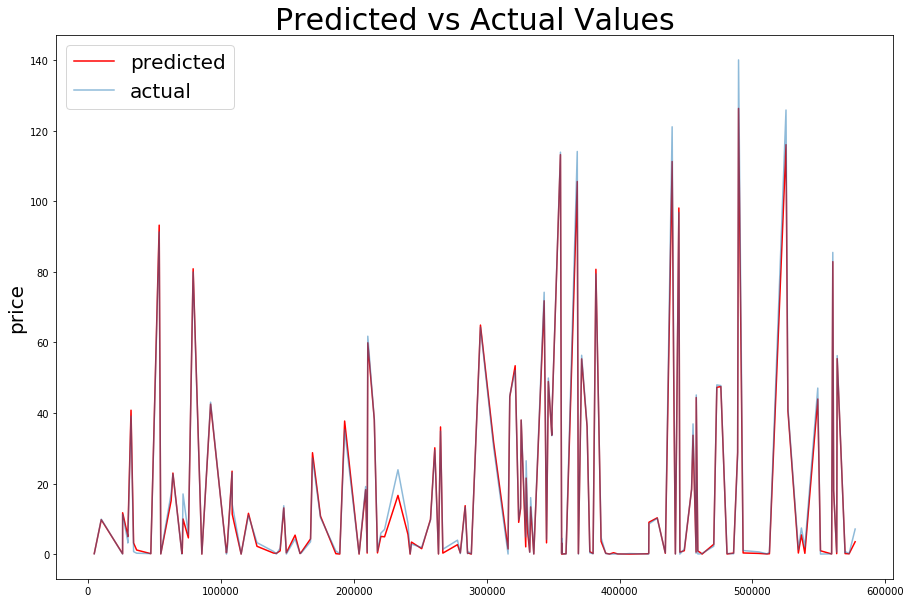

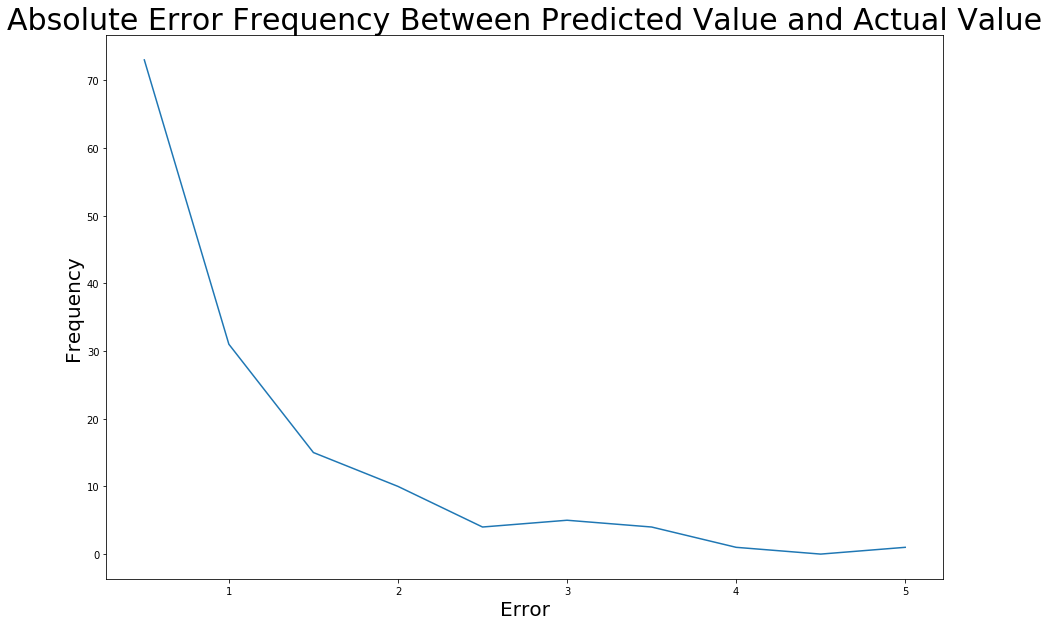

Mean absolute error (MAE):      0.868216
Mean squared error (MSE):       2.938061
R square (R^2):                 0.995237


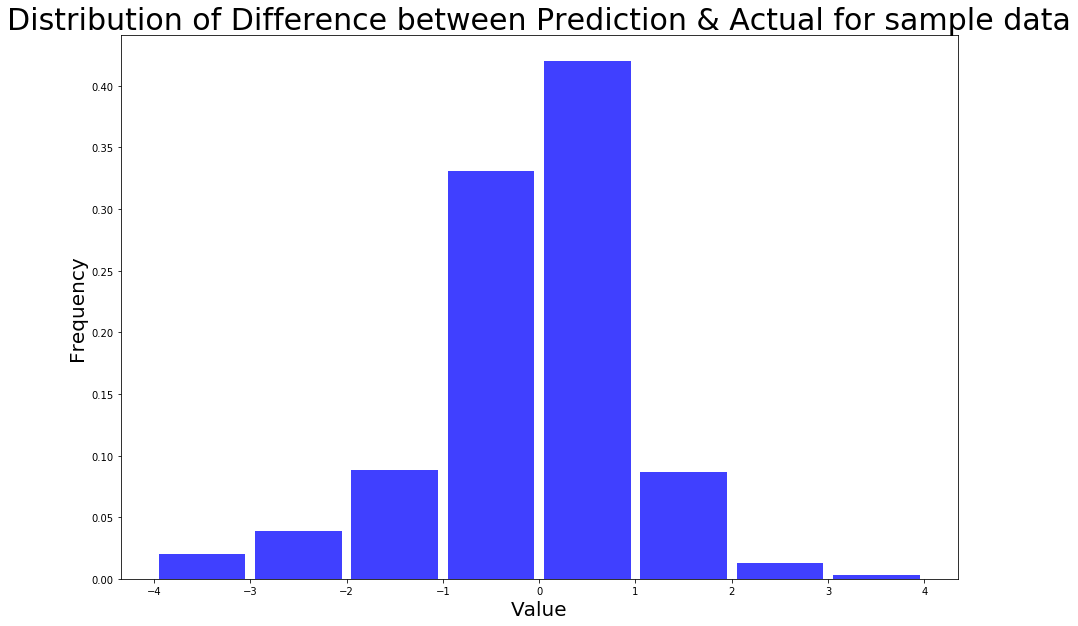

In [72]:
model_pred(AAPL, model, 'realized_vol')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>